# Анализ эффективности источников трафика Яндекс. Афиша.

<a name="describe"></a>
## Описание задачи 

Оценить эффективность привлечения трафика для Яндекс. Афиша и помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.

Данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши (визиты): /datasets/visits_log.csv ;
- выгрузка всех заказов за этот период (заказы): /datasets/orders_log.csv ;
- статистика рекламных расходов (расходы): /datasets/costs.csv. 


Необходимо проанализировать:
- как клиенты пользуются сервисом,
- когда делают первые покупки на сайте,
- сколько денег приносит компании каждый клиент,
- когда расходы на привлечение клиента окупаются.

Описание данных:

Файл visits_log.csv хранит лог сервера с информацией о посещениях сайта, orders_log.csv — информацию о заказах, а costs.csv — информацию о расходах на маркетинг.

Структура visits_log.csv
 - Uid — уникальный идентификатор пользователя,
 - Device — категория устройства пользователя,
 - Start Ts — дата и время начала сессии,
 - End Ts — дата и время окончания сессии,
 - Source Id — идентификатор источника перехода на сайт.
  
Структура orders_log.csv
 - Uid — уникальный идентификатор пользователя,
 - Buy Ts — дата и время заказа,
 - Revenue — сумма заказа.

Структура costs.csv
 - source_id — идентификатор рекламного источника,
 - dt — дата проведения рекламной кампании,
 - costs — расходы на эту кампанию.

Выручка измеряется в условных единицах — у.е.


<a name="contents"></a>
## Оглавление
- [Описание задачи.](#describe)
- [Оглавление.](#contents)
- [Изучение исходных данных.](#info)
- [Продуктовые метрики](#product_metrics)
- [Метрики электронной коммерции](#ecommerce_metrics)
- [Маркетинговые метрики](#marketing_metrics)
- [Общий вывод.](#conclusion)

<a name="info"></a>
## Изучение исходных данных. 

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import stats as st
import numpy as np

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# выгрузка dataframe и вывод на экран
visits_log = pd.read_csv('/datasets/visits_log.csv')
orders_log = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

display(visits_log.head())
display(orders_log.head())
display(costs.head())


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [3]:
visits_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [4]:
orders_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [5]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [6]:
visits_log.describe()

,Source Id,Uid
count,359400.000000,3.594000e+05
mean,3.750515,9.202557e+18
std,1.917116,5.298433e+18
min,1.000000,1.186350e+13
25%,3.000000,4.613407e+18
50%,4.000000,9.227413e+18
75%,5.000000,1.372824e+19
max,10.000000,1.844668e+19


In [7]:
orders_log.describe()

,Revenue,Uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


Аномалия: заказы с нулевым доходом - изучить сколько их и параметры их определяющие.
По доходу с заказа - среднее больше медианы. Это говорит о том, что мы имеем скошенный вправо дайтасет, а говоря простым языком - заказы с доходом сильно превышающим большинство. Проверить - чем обусловленны эти заказы. Возможно здесь можно заработать.

In [8]:
costs.describe()

,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


## Предобработка данных

### Название столбцов в едином виде: низкий регистр и слитное написание

In [9]:
visits_log.columns

Index(['Device', 'End Ts', 'Source Id', 'Start Ts', 'Uid'], dtype='object')

In [10]:
orders_log.columns

Index(['Buy Ts', 'Revenue', 'Uid'], dtype='object')

In [11]:
costs.columns

Index(['source_id', 'dt', 'costs'], dtype='object')

In [12]:
#Приводим названия колонок в низкому регистру и слитному написанию
visits_log.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
orders_log.columns = ['buy_ts', 'revenue', 'uid']
costs.columns = ['source_id', 'dt', 'costs']

In [13]:
#проверяем
visits_log.columns

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

In [14]:
#проверяем
orders_log.columns

Index(['buy_ts', 'revenue', 'uid'], dtype='object')

In [15]:
#проверяем
costs.columns

Index(['source_id', 'dt', 'costs'], dtype='object')

### Datatime для столбцов с датами и временем

In [16]:
#Для дат устанавливаем формат datatime
visits_log['end_ts'] = pd.to_datetime(visits_log['end_ts'])
visits_log['start_ts'] = pd.to_datetime(visits_log['start_ts'])
orders_log['buy_ts'] = pd.to_datetime(orders_log['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

### Проверка данных на логику

In [17]:
# проверка данных на логику: наличие записей, когда start_ts > end_ts:
visits_end_ts_start_ts = visits_log[visits_log['start_ts'] > visits_log['end_ts']]
visits_end_ts_start_ts

,device,end_ts,source_id,start_ts,uid
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453


In [18]:
#проверим заходили эти пользователи еще:
visits_log.query('uid in @visits_end_ts_start_ts.uid')

,device,end_ts,source_id,start_ts,uid
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986
5845,desktop,2018-03-17 17:55:00,2,2018-03-17 17:55:00,13092152539246794986
15861,desktop,2018-05-22 21:31:00,3,2018-05-22 20:55:00,4621202742905035453
92428,desktop,2018-05-21 13:04:00,4,2018-05-21 13:03:00,13092152539246794986
96975,desktop,2017-11-21 02:00:00,1,2017-11-21 01:24:00,13092152539246794986
100434,desktop,2017-11-27 14:44:00,1,2017-11-27 14:38:00,13092152539246794986
124454,desktop,2018-03-27 14:07:00,9,2018-03-27 13:47:00,4621202742905035453
124663,desktop,2018-04-15 14:58:00,9,2018-04-15 14:57:00,13092152539246794986
159507,desktop,2018-05-31 12:30:00,4,2018-05-31 12:12:00,13092152539246794986
163633,desktop,2018-03-25 12:56:00,9,2018-03-25 12:52:00,4621202742905035453


In [19]:
#проверим делали заказы эти пользователи:
orders_log.query('uid in @visits_end_ts_start_ts.uid')

,buy_ts,revenue,uid


Вывод: 
- Скорее всего 2018-03-25 был какой кратковременный сбой между 03:00 и 04:00. 
- За период сбоя было сделано 2 визита. Эти визиты не были первыми(мы считаем заходы по первому источнику)
- Заказов пользователи не делали.
- Принимаем решение оставить эти данные о визите данных пользователе 2018-03-25, т.к. значительно повлиять на изучаемы параметры они не смогут.

In [20]:
# проверка данных на логику: наличие записей, когда revenue < 0.
orders_log[orders_log['revenue']<0]

,buy_ts,revenue,uid


Проверим заказы с нулевой стоимостью.

In [21]:
#Проверим количество заказов с нулевой выручкой
orders_log[orders_log['revenue'] ==0]['revenue'].count()

51

In [22]:
#Посчитаем долю заказов с нулевой ценой по отношению к общему числу заказов
((orders_log[orders_log['revenue'] ==0]['revenue'].count())/(orders_log['revenue'].count())).round(4)

0.001

In [23]:
#как много пользователей делали нулевые заказы
orders_log[orders_log['revenue'] ==0]['uid'].nunique()

23

In [24]:
#как выглядят заказы с нулевой ценой
orders_log[orders_log['revenue'] ==0].head()

,buy_ts,revenue,uid
1802,2017-06-22 18:19:00,0.0,17030528792926543083
2787,2017-07-07 15:54:00,0.0,10281425020415612933
4783,2017-08-02 14:54:00,0.0,184148767273119549
5095,2017-08-09 14:48:00,0.0,5603453646174104178
5863,2017-08-23 13:43:00,0.0,5603453646174104178


Вывод: Заказы с нулевой ценой составляют около 0.1% всех заказов, их сделали 23 пользователя. Их влияние на результаты исследования будет минимальным.
Предположительная причина данного явления в заказах, которые оформляются по промокоду или на бесплатные мероприятия.

### Новые столбцы с датой, неделями, месяцем и годом в таблице с визитами.

In [25]:
visits_log['start_ts_year']  = visits_log['start_ts'].dt.year
visits_log['start_ts_month'] = visits_log['start_ts'].dt.month
visits_log['start_ts_week']  = visits_log['start_ts'].dt.week
visits_log['start_ts_date'] = visits_log['start_ts'].dt.date
visits_log.head()

,device,end_ts,source_id,start_ts,uid,start_ts_year,start_ts_month,start_ts_week,start_ts_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


### Количество источников трафика в разных данных

In [26]:
#Количество источников трафика и частота их использования в visits
visits_log['source_id'].value_counts()

4     101794
3      85610
5      66905
2      47626
1      34121
9      13277
10     10025
7         36
6          6
Name: source_id, dtype: int64

In [27]:
#Количество источников трафика и частота их использования в visits
costs['source_id'].value_counts()

5     364
9     363
3     363
1     363
10    363
4     363
2     363
Name: source_id, dtype: int64

Количество источников трафика в файле с визитами и файле с расходами не совпадает. В файле с визитами есть 2 источника(№6 и №7), которых нет в расходах. Оценка их вклада в общее количество посетителей показывает, что их количество пренебрежимо мало и не может влиять на результаты исследования. Принимаем решение удалить их из данных.

In [28]:
#сделаем срез по источникам 6 и 7.
visits_source_6_7 = visits_log.query('(source_id == 6) or (source_id == 7)')
visits_source_6_7['uid'].nunique()

40

В срез visits_source_6_7 попадает всего 40 уникальный пользователей, которые делали визиты на сайт. Их влияние принебрежимо мало. Удаляем их из данных по визитам.

In [29]:
#убрираем из данных visits_log пользователей, которые вошли в срез visits_source_6_7
visits_clear = visits_log.query('uid not in @visits_source_6_7.uid')
visits_clear['uid'].nunique()

228129

In [30]:
visits_clear.head()

,device,end_ts,source_id,start_ts,uid,start_ts_year,start_ts_month,start_ts_week,start_ts_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


In [31]:
#количество уникальных покупателей до чистки по срезу visits_source_6_7
orders_log['uid'].nunique()

36523

In [32]:
#убрираем из данных order_log пользователей, которые вошли в срез visits_source_6_7
orders_clear = orders_log.query('uid not in @visits_source_6_7.uid')
orders_clear['uid'].nunique()

36522

В срез visits_source_6_7 попадает всего 1 уникальный покупатель. Его влияние принебрежимо мало. Удаляем его из данных по заказам.

1) Приводим названия столцов к единому стилю: нижний регистр, слитное написание, латинские буквы.

2) Данные с датой и временем приводим к типу Datetime.

3) Создаем новые столбцы в таблице с визитами: дата, неделя, месяц, год начала визита.

4) Количество источников трафика в файле с визитами и файле с расходами не совпадает. В файле с визитами есть 2 источника(№6 и №7), которых нет в расходах. Оценка их вклада в общее количество посетителей показывает, что их количество пренебрежимо мало и не может влиять на результаты исследования. Принимаем решение удалить их из данных о визитах и заказах.
  
5) В визитах и расходах также не наблюдается источник трафика с id = 8 (с точки зрения нумерация он явно существует).
  
6) В заказах наблюдается большая неравномерность кол-ва заказов из разных источников. Необходимо проанализировать корреляцию расходов и заказов по источникам. 

7) По результатам предобработки данных получаем подготовленные, очищенные данные:
 - visits_clear - данные о визитах;
 - orders_clear - данные о заказах;
 - costs - данные о расходах.

<a name="product_metrics"></a>
## Продуктовые метрики.

### DAU, WAU, MAU средние значения за весь период. Графики изменения метрик во времени.

In [33]:
visits_clear.head()

,device,end_ts,source_id,start_ts,uid,start_ts_year,start_ts_month,start_ts_week,start_ts_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


In [34]:
#Посчитаем метрики. Сгруппируем данные по уникальным пользователям и найдём среднее:
dau_total_visits = visits_clear.groupby('start_ts_date').agg({'uid': 'nunique'}).mean()
wau_total_visits = (
    visits_clear.groupby(['start_ts_year', 'start_ts_week'])
    .agg({'uid': 'nunique'})
    .mean()
)
mau_total_visits = (
    visits_clear.groupby(['start_ts_year', 'start_ts_month'])
    .agg({'uid': 'nunique'})
    .mean()
)

print('Среднее значение DAU за весь период:', int(dau_total_visits))
print('Среднее значение WAU за весь период:', int(wau_total_visits))
print('Среднее значение MAU за весь период:', int(mau_total_visits))

Среднее значение DAU за весь период: 907
Среднее значение WAU за весь период: 5715
Среднее значение MAU за весь период: 23224


In [35]:
#Посчитаем метрики. Сгруппируем данные по уникальным пользователям и построим барные графики:
dau_total_visits_var = (visits_clear.groupby(['start_ts_date']).agg({'uid': 'nunique'})).reset_index()

wau_total_visits_var = (visits_clear.groupby(['start_ts_year', 'start_ts_week']).agg({'uid': 'nunique'})).reset_index()

mau_total_visits_var = (visits_clear.groupby(['start_ts_year', 'start_ts_month']).agg({'uid': 'nunique'})).reset_index()

In [36]:
dau_total_visits_var.columns=['start_ts_date','dau']
wau_total_visits_var.columns=['start_ts_year','start_ts_week','wau']
mau_total_visits_var.columns=['start_ts_year','start_ts_month','mau']

wau_total_visits_var.sample(5)

,start_ts_year,start_ts_week,wau
24,2017,46,8117
34,2018,4,7059
9,2017,31,2364
20,2017,42,7147
48,2018,18,3915


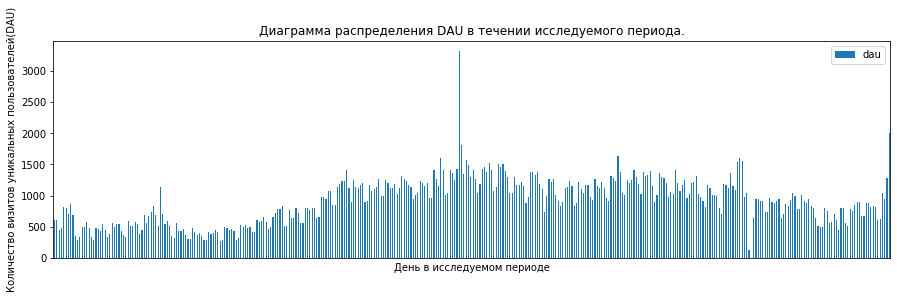

In [37]:
dau_total_visits_var.plot(x='start_ts_date', y='dau', kind='bar',figsize=(15, 4))
plt.xticks([])
plt.xlabel('День в исследуемом периоде')
plt.ylabel('Количество визитов уникальных пользователей(DAU)')
plt.title('Диаграмма распределения DAU в течении исследуемого периода.')
plt.show()

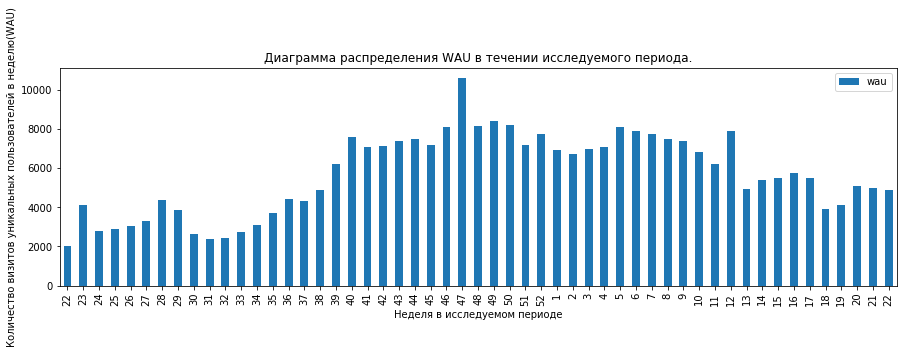

In [38]:
wau_total_visits_var.plot(x='start_ts_week', y='wau', kind='bar',figsize=(15, 4))
plt.xlabel('Неделя в исследуемом периоде')
plt.ylabel('Количество визитов уникальных пользователей в неделю(WAU)')
plt.title('Диаграмма распределения WAU в течении исследуемого периода.')
plt.show()

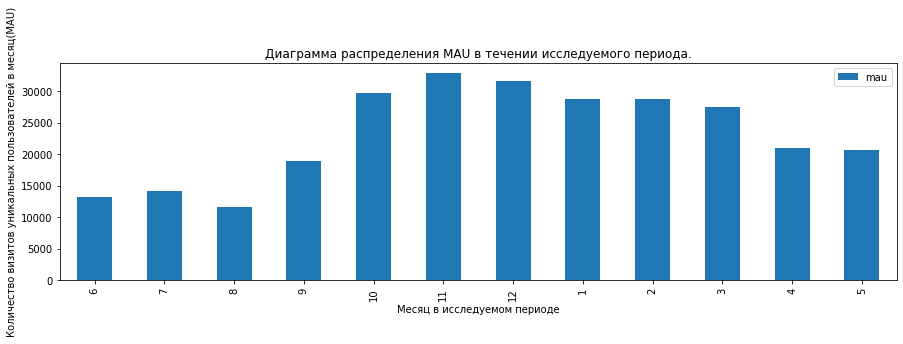

In [39]:
mau_total_visits_var.plot(x='start_ts_month', y='mau', kind='bar',figsize=(15, 4))
plt.xlabel('Месяц в исследуемом периоде')
plt.ylabel('Количество визитов уникальных пользователей в месяц(MAU)')
plt.title('Диаграмма распределения MAU в течении исследуемого периода.')
plt.show()

Вывод: 

- На графиках DAU, WAU, MAU виден рост с последующим спадом. Максимум достигается в ноябре-декабре 2017 года.
Скорее всего это сезонность (пик достигается в период предновогодних распродаж и мероприятий, а провал приходится на лето, когда многие уезжают в отпуск), но необходимо сравнить с суммарным графиком расходов на рекламу возможно такое распределение обусловено не только сезонностью, но расходами на рекламу.

- На графике DAU можно заметить повторяющиеся похожие участки, скорее всего это внутри-недельный цикл посетитилей.

### Среднее количество сессий на пользователя 

In [40]:
#создаем датафрейм для сессий
sessions_df = visits_clear.copy()
sessions_df.head()

,device,end_ts,source_id,start_ts,uid,start_ts_year,start_ts_month,start_ts_week,start_ts_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


In [41]:
#группируем по году, месяцу и считаем визиты уникальные и все. Затем переименовываем столбцы

sessions_per_user = sessions_df.groupby(['start_ts_year', 'start_ts_month']).agg(

   {'uid': ['count', 'nunique']}

)

sessions_per_user.columns = ['n_sessions', 'n_users']

In [42]:
#Среднее количество сессий на одного пользователя
sessions_per_user['sessions_per_user'] = (
    sessions_per_user['n_sessions'] / sessions_per_user['n_users']
)
sessions_per_user

n_sessions  n_users  sessions_per_user
start_ts_year start_ts_month                                        
2017          6                    16502    13256           1.244870
              7                    17825    14180           1.257052
              8                    14351    11627           1.234282
              9                    23902    18971           1.259923
              10                   37895    29685           1.276571
              11                   43963    32794           1.340581
              12                   41970    31547           1.330396
2018          1                    36930    28709           1.286356
              2                    37175    28745           1.293268
              3                    35678    27472           1.298704
              4                    26514    21007           1.262151
              5                    26633    20699           1.286681

In [43]:
#Среднее количество сессий в месяц на одного пользователя за весь период
sessions_per_user.reset_index()['sessions_per_user'].mean().round(2)

1.28

Вывод: среднее количество сессий на одного пользователя в месяц за весь период (показатель регулярности использования) составило 1.28 - выходит продуктом пользуются не очень часто.

### Продолжительность пользовательской сессии

In [44]:
#Найдём ASL — посчитаем длину всех сессий и вычислим среднее:
visits_clear['session_duration_sec'] = (
    visits_clear['end_ts'] - visits_clear['start_ts']
).dt.seconds

visits_clear['session_duration_sec'].mean()

643.4956280716206

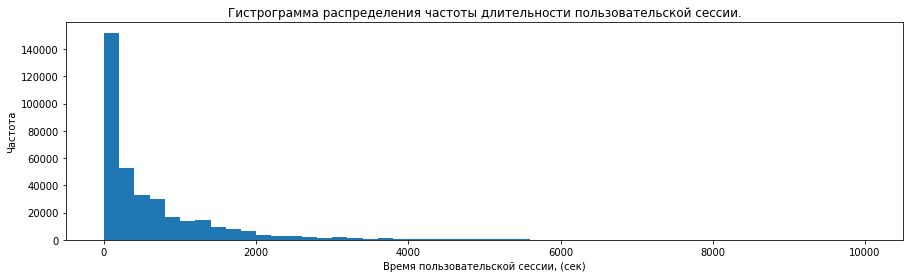

In [45]:
#Посмотрим распределение:
visits_clear['session_duration_sec'].plot(kind='hist', bins=50, figsize=(15, 4), range=(0, 10000))
plt.xlabel('Время пользовательской сессии, (сек)')
plt.ylabel('Частота')
plt.title('Гистрограмма распределения частоты длительности пользовательской сессии.')
plt.show()

Поскольку распределение на гистрограмме сильно отличается от нормального, то для оценки типичной пользовательской сессии используем характеристику - моду:

In [46]:
visits_clear['session_duration_sec'].mode()

0    60
dtype: int64

### Влияние типа устройства пользователя на длительность сессии.

In [47]:
#срез визитов с длительностью менее или равно 60 секунд
visits_clear_60 = visits_clear[visits_clear['session_duration_sec'] <=60].copy()
visits_clear_60.head()

,device,end_ts,source_id,start_ts,uid,start_ts_year,start_ts_month,start_ts_week,start_ts_date,session_duration_sec
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,9,35,2017-09-03,60
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312,2017,11,44,2017-11-05,60
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063,2017,11,45,2017-11-08,60


In [48]:
#соотношение touch устройст к дисплей в срезе сессий за 60 секунд
visits_clear_60.groupby('device').agg({'uid':'nunique'}).reset_index()

,device,uid
0,desktop,50987
1,touch,27045


Соотношение touch устройств к устройствам дисплей в срезе сессий за 60 секунд = 0.53

In [49]:
#соотношение touch устройст к дисплей в общем датасете
visits_clear.groupby('device').agg({'uid':'nunique'}).reset_index()

,device,uid
0,desktop,164491
1,touch,71335


Соотношение touch устройств к устройствам дисплей в общем датасете = 0.43.

Вывод: 

Типичная пользовательская сессия длиться 60 секунд. 

И тут два варианта: 
- либо пользователи легко и быстро находят то, то им нужно и если все устраивает покупают;
- либо у многих из них возникает проблема на каком-то этапе и они уходят.

Первый вариант вполне возможен, так как Яндекс.Афиша информационный сервис. Пользователи заходят не только для того, чтобы что-то купить. Они могут уточнить расписание, адрес, телефон или рейтинг. Эту информацию они вполне могут получить и осмыслить за 60 секунд.

Для верности мы рассмотрели также второй вариант, где у пользователя возникает нерешаемая проблема и он уходит. 
В качестве одной из гипотез мы проверили предположение о возможности проблем с мобильным приложением. В срезе с сессией менее 60 секунд соотношение устройств хоть и отличается в сторону увеличения, но не настолько, чтобы можно было говорить о серьезной проблеме с работой мобильной версии. Таким образом, останавливаемся на предположении о том, что пользователь быстро находит информацию и уходит, т.к. он не планировал покупку.

### Retention Rate для визитов пользователей.

Применим когортный анализ.

In [50]:
visits_clear.head()

,device,end_ts,source_id,start_ts,uid,start_ts_year,start_ts_month,start_ts_week,start_ts_date,session_duration_sec
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0


In [51]:
#Для каждого клиента получим дату его первого визита:
first_visit_date = visits_clear.groupby('uid')['start_ts_date'].min()
first_visit_date.head()

uid
11863502262781     2018-03-01
49537067089222     2018-02-06
297729379853735    2017-06-07
313578113262317    2017-09-18
325320750514679    2017-09-30
Name: start_ts_date, dtype: object

In [52]:
#изменим имя Series
first_visit_date.name = 'first_visit_date'
first_visit_date.head()

uid
11863502262781     2018-03-01
49537067089222     2018-02-06
297729379853735    2017-06-07
313578113262317    2017-09-18
325320750514679    2017-09-30
Name: first_visit_date, dtype: object

In [53]:
#Методом join() объединим датафрейм visits_log и Series first_visit_date по столбцу 'uid'
visits_clear = visits_clear.join(first_visit_date, on='uid')
visits_clear.head()

,device,end_ts,source_id,start_ts,uid,start_ts_year,start_ts_month,start_ts_week,start_ts_date,session_duration_sec,first_visit_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440,2018-03-09
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0,2017-12-27


In [54]:
#выделим из столбцов first_visit_date и start_ts месяцы. 
#Вызовем метод astype() и преобразуем значения столбцов к типу 'datetime64[M]'
visits_clear['first_visit_month'] = visits_clear['first_visit_date'].astype('datetime64[M]')

In [55]:
visits_clear['visit_month'] = visits_clear['start_ts'].astype('datetime64[M]')

In [56]:
visits_clear.head()

,device,end_ts,source_id,start_ts,uid,start_ts_year,start_ts_month,start_ts_week,start_ts_date,session_duration_sec,first_visit_date,first_visit_month,visit_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080,2017-12-20,2017-12-01,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680,2018-02-19,2018-02-01,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0,2017-07-01,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440,2018-03-09,2018-03-01,2018-05-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0,2017-12-27,2017-12-01,2017-12-01


In [57]:
#сгруппируем данные по когорте first_visit_month и месяцу визита visit_month
visits_grouped_by_cohorts = visits_clear.groupby(
    ['first_visit_month', 'visit_month']
).agg({'uid': 'nunique'})
visits_grouped_by_cohorts.head()

uid
first_visit_month visit_month       
2017-06-01        2017-06-01   13256
                  2017-07-01    1043
                  2017-08-01     712
                  2017-09-01     814
                  2017-10-01     909

In [58]:
# Найдём lifetime когорты.
visits_grouped_by_cohorts = visits_grouped_by_cohorts.reset_index()
visits_grouped_by_cohorts['cohort_lifetime'] = (
    visits_grouped_by_cohorts['visit_month']
    - visits_grouped_by_cohorts['first_visit_month']
)
visits_grouped_by_cohorts['cohort_lifetime'].head()

0     0 days
1    30 days
2    61 days
3    92 days
4   122 days
Name: cohort_lifetime, dtype: timedelta64[ns]

In [59]:
#Преобразуем 'cohort_lifetime' в число месяцев, прошедших между датами
visits_grouped_by_cohorts['cohort_lifetime'] = visits_grouped_by_cohorts[
    'cohort_lifetime'
] / np.timedelta64(1, 'M')
visits_grouped_by_cohorts['cohort_lifetime'].head()

0    0.000000
1    0.985647
2    2.004148
3    3.022649
4    4.008296
Name: cohort_lifetime, dtype: float64

In [60]:
# Округлим значения столбца cohort_lifetime методом round(), а затем приведём их к целочисленному типу методом astype('int'):
visits_grouped_by_cohorts['cohort_lifetime'] = (
    visits_grouped_by_cohorts['cohort_lifetime'].round().astype('int')
)
visits_grouped_by_cohorts.head()

,first_visit_month,visit_month,uid,cohort_lifetime
0,2017-06-01,2017-06-01,13256,0
1,2017-06-01,2017-07-01,1043,1
2,2017-06-01,2017-08-01,712,2
3,2017-06-01,2017-09-01,814,3
4,2017-06-01,2017-10-01,909,4


In [61]:
#Оставим в данных о месяце первого визита только год и месяц:
visits_grouped_by_cohorts['first_visit_month'] = visits_grouped_by_cohorts['first_visit_month'].dt.strftime('%Y-%m')
visits_grouped_by_cohorts.head()

,first_visit_month,visit_month,uid,cohort_lifetime
0,2017-06,2017-06-01,13256,0
1,2017-06,2017-07-01,1043,1
2,2017-06,2017-08-01,712,2
3,2017-06,2017-09-01,814,3
4,2017-06,2017-10-01,909,4


In [62]:
# Найдём исходное количество пользователей в когорте. Возьмём их число на нулевой месяц:
initial_users_count = visits_grouped_by_cohorts[visits_grouped_by_cohorts['cohort_lifetime'] == 0][['first_visit_month', 'uid']]
initial_users_count

,first_visit_month,uid
0,2017-06,13256
12,2017-07,13137
23,2017-08,10178
33,2017-09,16702
42,2017-10,25971
50,2017-11,27246
57,2017-12,25258
63,2018-01,22619
68,2018-02,22195
72,2018-03,20588


In [63]:
#переименуем столбец 
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

In [64]:
#Объединим данные по когортам с исходным количеством пользователей в когорте:
visits_grouped_by_cohorts = visits_grouped_by_cohorts.merge(initial_users_count,on='first_visit_month')
visits_grouped_by_cohorts.head()

,first_visit_month,visit_month,uid,cohort_lifetime,cohort_users
0,2017-06,2017-06-01,13256,0,13256
1,2017-06,2017-07-01,1043,1,13256
2,2017-06,2017-08-01,712,2,13256
3,2017-06,2017-09-01,814,3,13256
4,2017-06,2017-10-01,909,4,13256


In [65]:
#рассчитаем Retention Rate
visits_grouped_by_cohorts['retention'] = visits_grouped_by_cohorts['uid']/visits_grouped_by_cohorts['cohort_users']
visits_grouped_by_cohorts.head()

,first_visit_month,visit_month,uid,cohort_lifetime,cohort_users,retention
0,2017-06,2017-06-01,13256,0,13256,1.000000
1,2017-06,2017-07-01,1043,1,13256,0.078681
2,2017-06,2017-08-01,712,2,13256,0.053712
3,2017-06,2017-09-01,814,3,13256,0.061406
4,2017-06,2017-10-01,909,4,13256,0.068573


In [66]:
#Построим сводную таблицу Retention rate:
visits_cohort_pivot = visits_grouped_by_cohorts.pivot_table(
    index='first_visit_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum'
)
visits_cohort_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06,1.0,0.078681,0.053712,0.061406,0.068573,0.071439,0.061029,0.057785,0.052354,0.050845,0.040661,0.044961
2017-07,1.0,0.056101,0.051305,0.056177,0.058232,0.048185,0.045368,0.045749,0.038822,0.028621,0.027480,NaN
2017-08,1.0,0.076734,0.062782,0.062782,0.050108,0.044017,0.036353,0.039497,0.027903,0.026037,NaN,NaN
2017-09,1.0,0.085499,0.069213,0.050712,0.039396,0.037840,0.035864,0.024189,0.022812,NaN,NaN,NaN
2017-10,1.0,0.078588,0.052251,0.038890,0.034230,0.032228,0.021370,0.020369,NaN,NaN,NaN,NaN
2017-11,1.0,0.078287,0.044117,0.038685,0.033730,0.023416,0.021801,NaN,NaN,NaN,NaN,NaN
2017-12,1.0,0.055824,0.037968,0.031119,0.020271,0.019043,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,1.0,0.059729,0.039347,0.024979,0.020248,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,1.0,0.057085,0.025456,0.020095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
#Среднее значение Retention rate в первый месяц жизни кагорты
visits_cohort_pivot[1].mean().round(4)

0.0652

In [68]:
#Среднее значение Retention rate во второй месяц жизни когорты
visits_cohort_pivot[2].mean().round(4)

0.0463

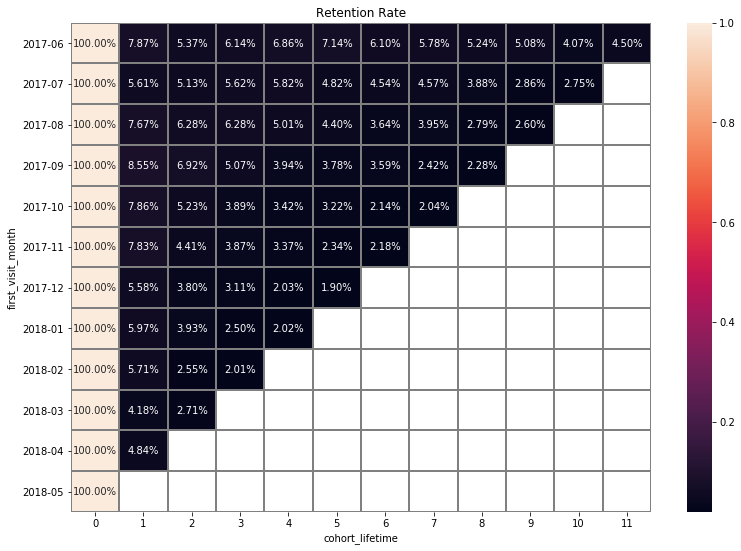

In [69]:
#Создадим тепловую карту для удобства анализа таблицы

plt.figure(figsize=(13, 9))
plt.title('Retention Rate')
plt.xlabel('Lifetime - время жизни когорты, мес.')
plt.ylabel('Первый месяц когорты')
sns.heatmap(visits_cohort_pivot, annot=True, fmt='.2%', linewidths=1, linecolor='gray')
plt.show()

*Вывод:*

1) Первое, что бросается в глаза, это очень резкое падение среднего retention rate после 0-месяца: со 100 до 6.5%. Это происходит во всех когортах. Таким образом, данное явление постоянное. Важно понять причины его обуславливающие, здесь явно есть над чем поработать.

2) При переходе с 1-го на 2 -й месяц жизни средний retention rate снижается с 6.5 % до 4.5%. Это уже не так катастрофически, как при переходе с 0 на 1 месяц. Но важно отметить, что в дальнейшем тенденция падения сохраняется.

3) При рассмотрении динамики по когортам можно заметить тренд на снижение retention rate от 06.2017 по 04.2018 для 1 месяца жизни. Похожая динамика наблюдается в других периодах жизни когорт (с 8% до 4%).

<a name="ecommerce_metrics"></a>
## Метрики электронной коммерции.

### Среднее время, которое проходит от посещения до покупки

In [70]:
orders_clear.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [71]:
first_orders_date= orders_clear.groupby('uid').agg({'buy_ts': ['min']}).reset_index()

In [72]:
first_orders_date.columns = ['uid','buy_ts_first']

In [73]:
first_orders_date.head()

,uid,buy_ts_first
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00


In [74]:
#Объединим данные о визитах и заказах
visits_orders = first_orders_date.join(first_visit_date, on='uid')
visits_orders.head()

,uid,buy_ts_first,first_visit_date
0,313578113262317,2018-01-03 21:51:00,2017-09-18
1,1575281904278712,2017-06-03 10:13:00,2017-06-03
2,2429014661409475,2017-10-11 18:33:00,2017-10-11
3,2464366381792757,2018-01-28 15:54:00,2018-01-27
4,2551852515556206,2017-11-24 10:14:00,2017-11-24


In [75]:
#Создадим новый столбец buy_ts_first_date для перевода времени покупки в дату
visits_orders['buy_ts_first_date'] = visits_orders['buy_ts_first'].dt.date
visits_orders.head()

,uid,buy_ts_first,first_visit_date,buy_ts_first_date
0,313578113262317,2018-01-03 21:51:00,2017-09-18,2018-01-03
1,1575281904278712,2017-06-03 10:13:00,2017-06-03,2017-06-03
2,2429014661409475,2017-10-11 18:33:00,2017-10-11,2017-10-11
3,2464366381792757,2018-01-28 15:54:00,2018-01-27,2018-01-28
4,2551852515556206,2017-11-24 10:14:00,2017-11-24,2017-11-24


In [76]:
#добавим столбец со временем (днями) от первого визита до первой покупки
visits_orders['t_delta'] = visits_orders['buy_ts_first_date'] - visits_orders['first_visit_date']
visits_orders['t_delta'] = (visits_orders['t_delta']/ np.timedelta64(1, 'D')).round().astype('int')
visits_orders.head()

,uid,buy_ts_first,first_visit_date,buy_ts_first_date,t_delta
0,313578113262317,2018-01-03 21:51:00,2017-09-18,2018-01-03,107
1,1575281904278712,2017-06-03 10:13:00,2017-06-03,2017-06-03,0
2,2429014661409475,2017-10-11 18:33:00,2017-10-11,2017-10-11,0
3,2464366381792757,2018-01-28 15:54:00,2018-01-27,2018-01-28,1
4,2551852515556206,2017-11-24 10:14:00,2017-11-24,2017-11-24,0


In [77]:
#Рассчитаем среднее количество дней от первого визита до первой покупки
visits_orders['t_delta'].mean()

16.896363835496413

In [78]:
#Распределение продолжительности периода от первого визита до первой покупки
visits_orders['t_delta'].describe()

count    36522.000000
mean        16.896364
std         47.071762
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        363.000000
Name: t_delta, dtype: float64

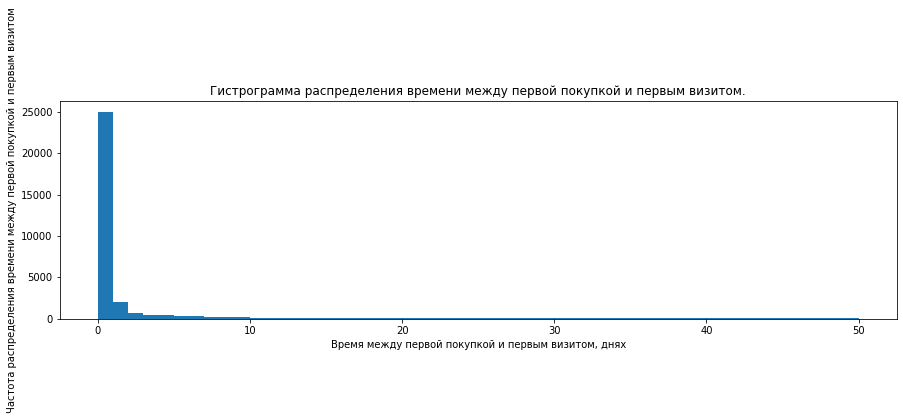

In [79]:
#Посмотрим распределение:
visits_orders['t_delta'].plot(kind='hist', bins=50, figsize=(15, 4), range=(0,50))
plt.xlabel('Время между первой покупкой и первым визитом, днях')
plt.ylabel('Частота распределения времени между первой покупкой и первым визитом')
plt.title('Гистрограмма распределения времени между первой покупкой и первым визитом.')
plt.show()

In [80]:
#самое частое значение - мода:
visits_orders['t_delta'].mode()

0    0
dtype: int64

Поскольку большинство заказов делается в день первого визита, то выполняем более детальный расчет с точносью до минут.

In [81]:
#Для каждого клиента получим дату и время его первого визита:
first_visit_time = visits_clear.groupby('uid')['start_ts'].min().copy()
first_visit_time.head()

uid
11863502262781    2018-03-01 17:27:00
49537067089222    2018-02-06 15:55:00
297729379853735   2017-06-07 18:47:00
313578113262317   2017-09-18 22:49:00
325320750514679   2017-09-30 14:29:00
Name: start_ts, dtype: datetime64[ns]

In [82]:
#добавим к данным о заказах данные с более точным времени первого визита
visits_orders_time = first_orders_date.join(first_visit_time, on='uid')
visits_orders_time.head()

,uid,buy_ts_first,start_ts
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00


In [83]:
#добавим столбец со временем от первого визита до первой покупки и посчитае количество минут
visits_orders_time['t_delta_time'] = visits_orders_time['buy_ts_first'] - visits_orders_time['start_ts']
visits_orders_time['t_delta_time'] = (visits_orders_time['t_delta_time']/ np.timedelta64(1, 'm')).round().astype('int')
visits_orders_time.head()

,uid,buy_ts_first,start_ts,t_delta_time
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,154022
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,79
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,1184
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0


In [84]:
#Распределение продолжительности периода (в минутах) от первого визита до первой покупки
visits_orders_time['t_delta_time'].describe()

count     36522.000000
mean      24340.840863
std       67785.583559
min           0.000000
25%           4.000000
50%          16.000000
75%        2897.500000
max      523144.000000
Name: t_delta_time, dtype: float64

In [85]:
#самое частое значение - мода:
visits_orders_time['t_delta_time'].mode()

0    1
dtype: int64

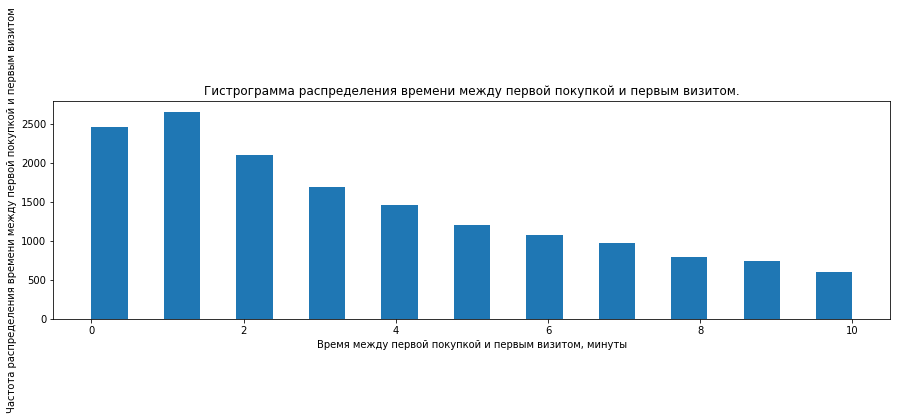

In [86]:
#Посмотрим распределение времени:
visits_orders_time['t_delta_time'].plot(kind='hist', bins=21, figsize=(15, 4), range=(0,10))
plt.xlabel('Время между первой покупкой и первым визитом, минуты')
plt.ylabel('Частота распределения времени между первой покупкой и первым визитом')
plt.title('Гистрограмма распределения времени между первой покупкой и первым визитом.')
plt.show()

*Вывод:*

График распределения далек от нормального и сильно скошен вправо, что обусловлено наличием небольшого количества сильно отклоняющихся значений.
Для корректной оценки характерного значения необходимо использовать моду - наиболее частое значение. В данном случае, она составляет 0 дней, т.е. в большинстве случаев первая покупка совершается в день первого визита. Поэтой причине был сделан более делатальный расчет (с точностью до минуты). Согласно его результатам самое частое значение времени от посещения до покупки составляет 1 минута. Т.е. зашел посмотреть расписание или адрес и сразу заказал билеты. Скорее всего это особенность данного типа сервисов (продажа билетов).

### Среднее количество покупок на одного покупателя за период.

In [87]:
orders_clear.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [88]:
first_orders_date.head()

,uid,buy_ts_first
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00


In [89]:
orders_log_with_first = orders_clear.merge(first_orders_date, on='uid', how ='left')
orders_log_with_first.head()

,buy_ts,revenue,uid,buy_ts_first
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00


In [90]:
# Время между первым и текущим заказом
orders_log_with_first['t_delta'] = orders_log_with_first ['buy_ts'] - orders_log_with_first['buy_ts_first']
orders_log_with_first.head()

,buy_ts,revenue,uid,buy_ts_first,t_delta
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,0 days
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,0 days
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,0 days
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,0 days
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,0 days


In [91]:
orders_log_with_first['t_delta_month'] = (orders_log_with_first['t_delta'] / np.timedelta64(1, 'M')).round().astype('int')
orders_log_with_first.head()

,buy_ts,revenue,uid,buy_ts_first,t_delta,t_delta_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,0 days,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,0 days,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,0 days,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,0 days,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,0 days,0


In [92]:
order_six_month = orders_log_with_first[orders_log_with_first['t_delta_month']<6]
order_six_month.head()

,buy_ts,revenue,uid,buy_ts_first,t_delta,t_delta_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,0 days,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,0 days,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,0 days,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,0 days,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,0 days,0


In [93]:
order_six_month_count = order_six_month.groupby('uid').agg({'revenue': ['count', 'sum']}).reset_index()
order_six_month_count.columns=['uid','count_order', 'revenue_sum']
order_m6_mean = order_six_month_count['count_order'].mean().round(2)

Среднее количество покупок за 6 месяцев:

In [94]:
order_m6_mean

1.32

*Вывод:*

Среднее количество покупок за 6 месяцев для уникального покупателя - 1.32. Этот показатель хорошо коррелирует с данными о поведении когорт при визитах - после первого месяца возвращается очень маленькое количество пользователей. Здесь также наблюдается отток клиентов  - лишь немногие делают второй заказ. Необходимо понять причины.

### Средний чек - изменение во времени.

In [95]:
orders_clear.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [96]:
orders_clear['order_month'] = orders_clear['buy_ts'].astype('datetime64[M]')
orders_clear.head()

,buy_ts,revenue,uid,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01


In [97]:
orders_clear['order_month'] = orders_clear['order_month'].dt.strftime('%Y-%m')
orders_clear.head()

,buy_ts,revenue,uid,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06


In [98]:
order_mean_cheque = orders_clear.groupby('order_month').agg({'revenue': ['mean']}).reset_index()
order_mean_cheque.columns=['order_mean_cheque','revenue_mean']

Средний чек по месяцам:

In [99]:
order_mean_cheque.round(2)

,order_mean_cheque,revenue_mean
0,2017-06,4.06
1,2017-07,5.31
2,2017-08,4.85
3,2017-09,5.42
4,2017-10,4.93
5,2017-11,4.78
6,2017-12,5.85
7,2018-01,4.11
8,2018-02,4.84
9,2018-03,5.41


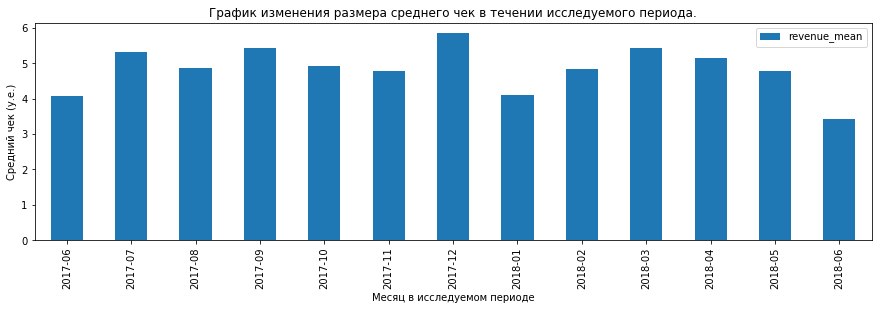

In [100]:
order_mean_cheque.plot(x='order_mean_cheque', y='revenue_mean', kind='bar',figsize=(15, 4))
plt.xlabel('Месяц в исследуемом периоде')
plt.ylabel('Средний чек (y.e.)')
plt.title('График изменения размера среднего чек в течении исследуемого периода.')
plt.show()

*Вывод:*

Размер среднего чека во времени изменяется синусоидально - циклическими периодами, состоящими из снижения и роста. Скорее всего это обусловлено сезонностью.

### Изменение LTV на покупателя по когортам

In [101]:
orders_clear.head()

,buy_ts,revenue,uid,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06


In [102]:
#выделим месяцы из дат в таблице с заказами
orders_clear['order_month'] = orders_clear['buy_ts'].astype('datetime64[M]')
orders_clear.head()

,buy_ts,revenue,uid,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01


In [103]:
#найдем месяц первой покупки каждого покупателя
first_orders = orders_clear.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
first_orders.head()

,uid,first_order_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


In [104]:
# Посчитаем количество новых покупателей за каждый месяц:
cohort_sizes = (
    first_orders.groupby('first_order_month')
    .agg({'uid': 'nunique'})
    .reset_index()
)
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes.head()

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1369
3,2017-09-01,2581
4,2017-10-01,4340


In [105]:
#Построим когорты, добавив месяц первой покупки каждого покупателя в таблицу с заказами:
orders_new = orders_clear.merge(first_orders, on='uid', how='left')
orders_new.head()

,buy_ts,revenue,uid,order_month,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01


In [106]:
#Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку
cohorts = (
    orders_new.groupby(['first_order_month', 'order_month'])
    .agg({'revenue': 'sum'})
    .reset_index()
)
cohorts.head()

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


In [107]:
# Добавим в таблицу данные о том, сколько людей первый раз совершили покупку в каждый месяц:
report = cohorts.merge(cohort_sizes, on='first_order_month', how='left')
report.head()

,first_order_month,order_month,revenue,n_buyers
0,2017-06-01,2017-06-01,9557.49,2023
1,2017-06-01,2017-07-01,981.82,2023
2,2017-06-01,2017-08-01,885.34,2023
3,2017-06-01,2017-09-01,1931.30,2023
4,2017-06-01,2017-10-01,2068.58,2023


In [108]:
#Маржинальность = 100%
margin_rate = 1

In [109]:
#рассчитаем валовую прибыль
report['gp'] = report['revenue'] * margin_rate

In [110]:
#Сформируем столбец возраста когорты
report['age'] = (report['order_month']- report['first_order_month']) / np.timedelta64(1, 'M')

In [111]:
report['age'] = report['age'].round().astype('int')

In [112]:
report.head()

,first_order_month,order_month,revenue,n_buyers,gp,age
0,2017-06-01,2017-06-01,9557.49,2023,9557.49,0
1,2017-06-01,2017-07-01,981.82,2023,981.82,1
2,2017-06-01,2017-08-01,885.34,2023,885.34,2
3,2017-06-01,2017-09-01,1931.30,2023,1931.30,3
4,2017-06-01,2017-10-01,2068.58,2023,2068.58,4


In [113]:
#найдём LTV
report['ltv'] = report['gp'] / report['n_buyers']
report.head()

,first_order_month,order_month,revenue,n_buyers,gp,age,ltv
0,2017-06-01,2017-06-01,9557.49,2023,9557.49,0,4.724414
1,2017-06-01,2017-07-01,981.82,2023,981.82,1,0.485329
2,2017-06-01,2017-08-01,885.34,2023,885.34,2,0.437637
3,2017-06-01,2017-09-01,1931.30,2023,1931.30,3,0.954671
4,2017-06-01,2017-10-01,2068.58,2023,2068.58,4,1.022531


In [114]:
#сводная таблица LTV по месяцам
output = report.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean').round(2)
output

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,0.49,0.44,0.95,1.02,0.74,0.95,0.58,0.55,0.61,0.57,0.26
2017-07-01,6.01,0.34,0.62,0.36,0.18,0.16,0.12,0.14,0.16,0.15,0.16,NaN
2017-08-01,5.28,0.47,0.46,0.39,0.49,0.28,0.21,0.41,0.29,0.19,NaN,NaN
2017-09-01,5.64,1.12,0.52,3.98,0.40,0.65,0.70,0.24,0.18,NaN,NaN,NaN
2017-10-01,5.00,0.54,0.19,0.16,0.15,0.12,0.08,0.12,NaN,NaN,NaN,NaN
2017-11-01,5.15,0.40,0.20,0.32,0.15,0.05,0.11,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.74,0.26,0.93,1.07,0.31,0.34,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.14,0.29,0.30,0.14,0.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.16,0.28,0.08,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


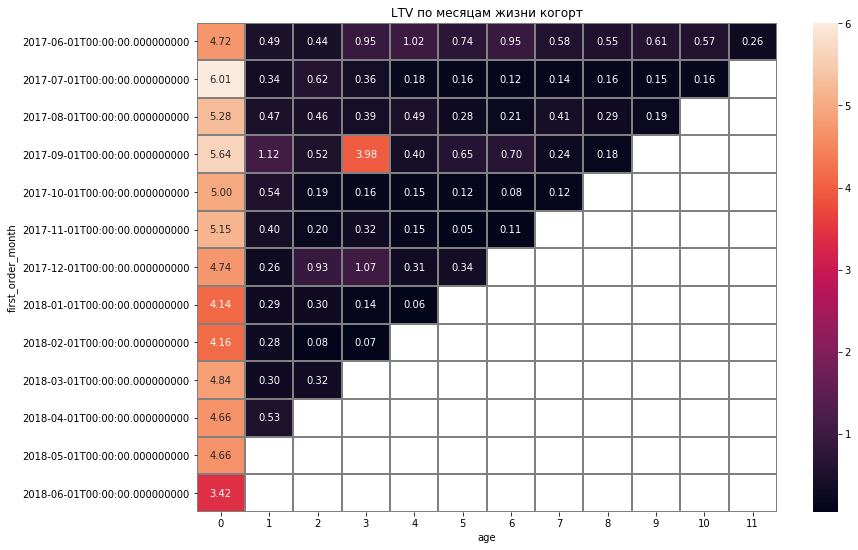

In [115]:
#Тепловая карта LTV по месяцам 
plt.figure(figsize=(13, 9))
plt.title('LTV по месяцам жизни когорт')
sns.heatmap(output, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.show()

*Вывод:*
 
1) Интересная аномалия наблюдается с LTV в когорте 2017-09-01 на третьем месяце жизни - его значение на порядок превышает показатели других когорт и становится сопоставимо с нулевым месяцем жизни. Желательно узнать, чем оно было вызвано. Возможно получиться распространить его показатели на другие когорты. 
Надо отметить, что эта когорта имеет и за другие месяцы жизни отличные показатели: 1-й , 5-й, 6-й месяцы. Они не так сильно выбиваются, но все равно имеют намного лучшие значения по сравнению с другими когортами.  

2) Когорта 2017-12-01 (второй и третий месяцы жизни) и когорта 2017-06-01 (третий, четвертый, пятый и шестой месяцы жизни) имеют LTV в несколько раз превышающий значения в других когортах.

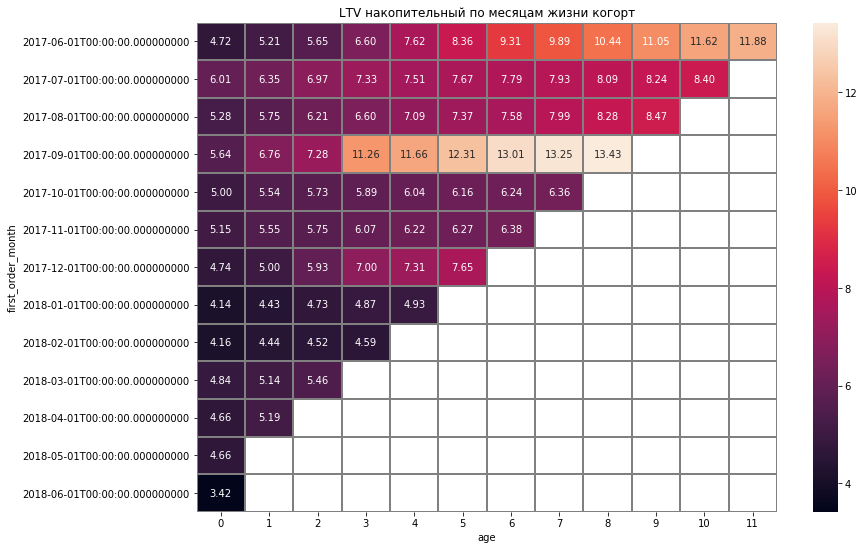

In [116]:
# сводная таблица LTV по месяцам с накопительным итогом
output_cumsum = output.cumsum(axis=1).round(2)

#Тепловая карта LTV по месяцам 
plt.figure(figsize=(13, 9))
plt.title('LTV накопительный по месяцам жизни когорт')
sns.heatmap(output_cumsum, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.show()

In [117]:
#отфильтруем когорты с сроком жизни 6 и более месяцев
report_life_six = report[report['first_order_month']<='2017-11-01']
report_life_six.head()

,first_order_month,order_month,revenue,n_buyers,gp,age,ltv
0,2017-06-01,2017-06-01,9557.49,2023,9557.49,0,4.724414
1,2017-06-01,2017-07-01,981.82,2023,981.82,1,0.485329
2,2017-06-01,2017-08-01,885.34,2023,885.34,2,0.437637
3,2017-06-01,2017-09-01,1931.30,2023,1931.30,3,0.954671
4,2017-06-01,2017-10-01,2068.58,2023,2068.58,4,1.022531


In [118]:
output_six = report_life_six.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean').round(2)
output_six

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,0.49,0.44,0.95,1.02,0.74,0.95,0.58,0.55,0.61,0.57,0.26
2017-07-01,6.01,0.34,0.62,0.36,0.18,0.16,0.12,0.14,0.16,0.15,0.16,NaN
2017-08-01,5.28,0.47,0.46,0.39,0.49,0.28,0.21,0.41,0.29,0.19,NaN,NaN
2017-09-01,5.64,1.12,0.52,3.98,0.40,0.65,0.70,0.24,0.18,NaN,NaN,NaN
2017-10-01,5.00,0.54,0.19,0.16,0.15,0.12,0.08,0.12,NaN,NaN,NaN,NaN
2017-11-01,5.15,0.40,0.20,0.32,0.15,0.05,0.11,NaN,NaN,NaN,NaN,NaN


In [119]:
# сводная таблица LTV по месяцам для когорт с жизньью более 6 месяцев с накопительным итогом
output_six_cumsum = output_six.cumsum(axis=1).round(2).fillna('') 
output_six_cumsum

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.60,7.62,8.36,9.31,9.89,10.44,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.51,7.67,7.79,7.93,8.09,8.24,8.4,
2017-08-01,5.28,5.75,6.21,6.60,7.09,7.37,7.58,7.99,8.28,8.47,,
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.43,,,
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11-01,5.15,5.55,5.75,6.07,6.22,6.27,6.38,,,,,


In [120]:
#усредним значения каждой колонки и сложим таблицу в единую строку(средний для разных когорт LTV за на каждый месяц жизни)
output_six_cumsum_mean =output_six_cumsum.mean(axis=0).round(2).reset_index()
output_six_cumsum_mean.columns = ['age','ltv_mean']
output_six_cumsum_mean

,age,ltv_mean
0,0,5.30
1,1,5.86
2,2,6.26
3,3,7.29
4,4,7.69
5,5,8.02
6,6,8.38


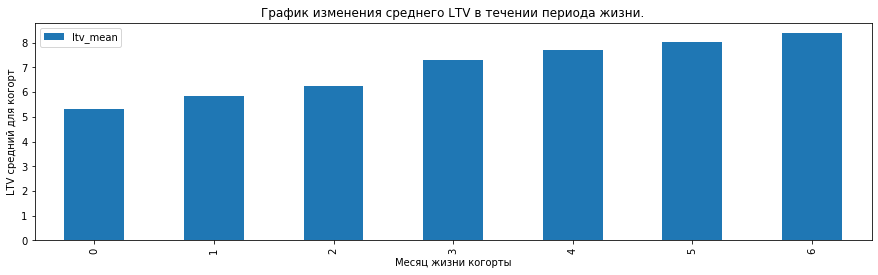

In [121]:
# Изменение среднего LTV на барном графике
output_six_cumsum_mean.plot(x='age', y='ltv_mean', kind='bar',figsize=(15, 4))
plt.xlabel('Месяц жизни когорты')
plt.ylabel('LTV средний для когорт')
plt.title('График изменения среднего LTV в течении периода жизни.')
plt.show()

*Вывод:*
 - Средний по когортам за 6 месяцев жизни LTV растет, как и должно быть величиной, которую считают нарастающим итогом.
 - Видно, что в начале( с 0 по 3 месяцы жизни) этот рост более значительный, чем в последующие.
 - Аномалия по LTV в когорте 2017-09-01 на третьем месяце жизни требует более детального изучения. Если это не ошибка в данных, 
   то можно попробовать выявить причины этого явления и распространить его на новые когорты.
 - Высокие показатели когорты 2017-06-01 также требуеют более глубокого изучения. Они не так резко отличаются от остальных, как    в когорте 2017-09-01, и имеют более четкую динамику, что может говорить о наличии системность, а не ошибки в данных. 

<a name="marketing_metrics"></a>
## Маркетинговые метрики.

### Расходы на маркетинг. Распределение по источникам трафика.

In [122]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Суммарные расходы на маркетинг за весь период с распределением по источникам:

In [123]:
costs_source = costs.groupby('source_id').agg({'costs': ['sum']}).reset_index()
costs_source.columns = ['source_id','costes_sum_source']
costs_source

,source_id,costes_sum_source
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


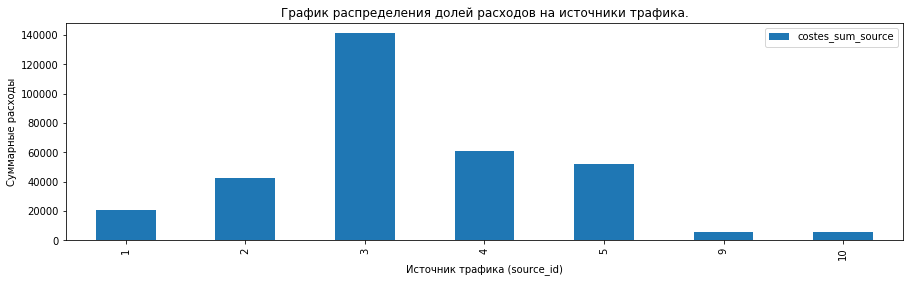

In [124]:
# Построим барный график распределения долей расходов на источники трафика
costs_source.plot(x='source_id', y='costes_sum_source', kind='bar',figsize=(15, 4))
plt.xlabel('Источник трафика (source_id)')
plt.ylabel('Суммарные расходы')
plt.title('График распределения долей расходов на источники трафика.')
plt.show()

Суммарные расходы на маркетинг по всем источника (у.е.):

In [125]:
costs_total = costs_source['costes_sum_source'].sum()
costs_total.round() 

329132.0

Расходы на маркетинг по месяцам

In [126]:
#выделим месяцы из дат в таблице с расходами
costs['costs_month'] = costs['dt'].astype('datetime64[M]')
costs.head()

,source_id,dt,costs,costs_month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [127]:
#сгруппируем по месяцу расхода и просуммируем
costs_group_mes = costs.groupby('costs_month').agg({'costs': 'sum'}).reset_index()
costs_group_mes

,costs_month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


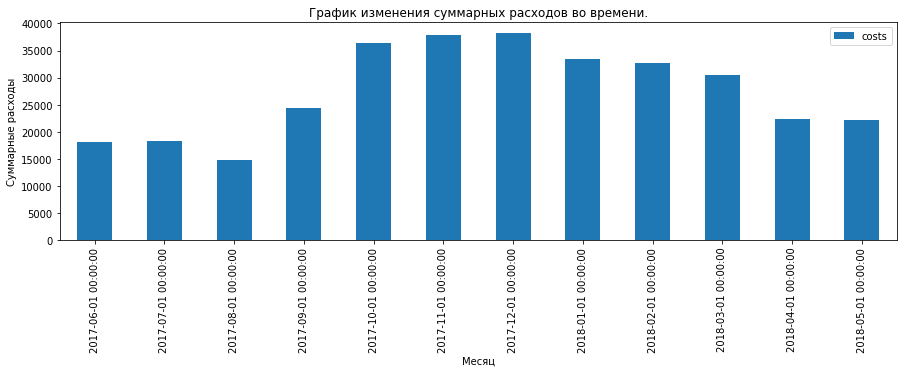

In [128]:
# Построим барный график изменения суммарных расходов во времени
costs_group_mes.plot(x='costs_month', y='costs', kind='bar',figsize=(15, 4))
plt.xlabel('Месяц')
plt.ylabel('Суммарные расходы')
plt.title('График изменения суммарных расходов во времени.')
plt.show()

*Вывод:*

Сравнение графиков кол-ва уникальных посетителей (WAU, MAU) и расходов на рекламу показывает схожие тендеции - также имеется рост с последующим снижением. При этом пик также приходится на ноябрь и декабрь 2017 года.


In [129]:
#сводник расходов по месяцам и источникам
costs_pivot = costs.pivot_table(index='costs_month', columns='source_id', values='costs', aggfunc='sum')
costs_pivot

source_id,1,2,3,4,5,9,10
costs_month,,,,,,,
2017-06-01,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22
2017-07-01,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82
2017-08-01,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57
2017-09-01,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67
2017-10-01,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24
2017-11-01,2445.16,5247.68,17025.34,5388.82,6325.34,683.18,792.36
2017-12-01,2341.20,4897.80,16219.52,7680.47,5872.52,657.98,645.86
2018-01-01,2186.18,4157.74,14808.78,5832.79,5371.52,547.16,614.35
2018-02-01,2204.48,4474.34,14228.56,5711.96,5071.31,551.50,480.88


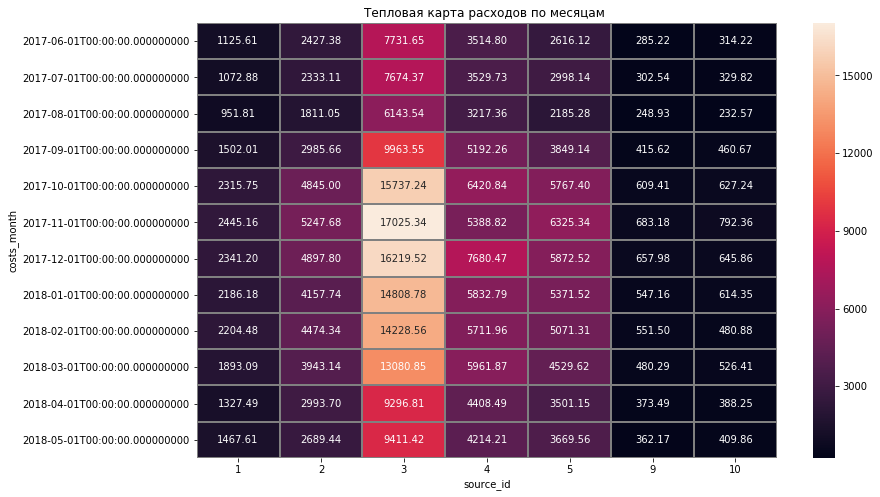

In [130]:
#Тепловая карта расходов по месяцам 
plt.figure(figsize=(13, 8))
plt.title('Тепловая карта расходов по месяцам ')
sns.heatmap(costs_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.show()

In [131]:
#сбросим индексы, чтобы взять costs_month в ось х
costs_pivot_reset=costs_pivot.reset_index()
costs_pivot_reset

source_id,costs_month,1,2,3,4,5,9,10
0,2017-06-01,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22
1,2017-07-01,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82
2,2017-08-01,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57
3,2017-09-01,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67
4,2017-10-01,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24
5,2017-11-01,2445.16,5247.68,17025.34,5388.82,6325.34,683.18,792.36
6,2017-12-01,2341.20,4897.80,16219.52,7680.47,5872.52,657.98,645.86
7,2018-01-01,2186.18,4157.74,14808.78,5832.79,5371.52,547.16,614.35
8,2018-02-01,2204.48,4474.34,14228.56,5711.96,5071.31,551.50,480.88
9,2018-03-01,1893.09,3943.14,13080.85,5961.87,4529.62,480.29,526.41


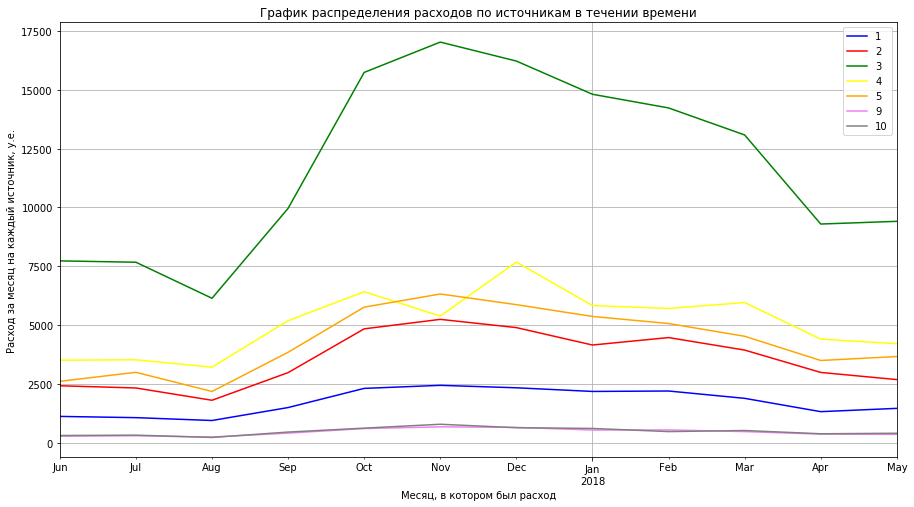

In [132]:
#график распределения расходов по источникам в течении времени  

ax=costs_pivot_reset.plot(color='blue', alpha = 1, y=1 , x='costs_month', figsize=(15, 8), grid = True)

costs_pivot_reset.plot(color='red', alpha = 1, y =2, x='costs_month', figsize=(15, 8), grid=True,ax=ax)

costs_pivot_reset.plot(color='green', alpha = 1, y =3 , x='costs_month', figsize=(15, 8), grid=True, ax=ax)

costs_pivot_reset.plot(color='yellow', alpha = 1, y =4, x='costs_month', figsize=(15, 8),grid=True, ax=ax)

costs_pivot_reset.plot(color='orange', alpha = 1, y =5, x='costs_month', figsize=(15, 8), grid=True, ax=ax)

costs_pivot_reset.plot(color='violet', alpha = 1, y =9, x='costs_month', figsize=(15, 8), grid=True, ax=ax)

costs_pivot_reset.plot(color='grey', alpha = 1, y =10, x='costs_month', figsize=(15, 8), grid=True, ax=ax)


plt.xlabel('Месяц, в котором был расход')

plt.ylabel('Расход за месяц на каждый источник, у.е.')

plt.title('График распределения расходов по источникам в течении времени')

plt.show()

*Вывод:*

- Расходы на разные источники трафика распределены неравномерно.
- В августе 2017 года наблюдается снижением расходов по всем источникам, с последующим увеличением.
- Максимум расходов по всем источникам (кроме 4-го у него в этот месяц наблюдается локальный минимум) был достигнут ноябре 2017 года( у 4-го источника абсолютный максимум был достигнут в декабре 2017 года).
- В 2018 году наблюдается постепенное снижение расходов по всем источникам. Фактически их значения возвращаются к величинам соответствующим 2017 году в эти же месяцы. Источники 3,4,5 в конце исследуемого периода имеют расходы немного выше, чем в аналогичный период 2017 года.


### Средний CAC для всего проекта и для каждого источника трафика.

In [133]:
#посчитаем количество уникальных покупателей
uid_orders_unique = orders_clear['uid'].nunique()
uid_orders_unique

36522

Средний CAC для всего проекта:

In [134]:
cac_mean_total = costs_total / uid_orders_unique
cac_mean_total.round(2)

9.01

In [135]:
visits_clear.head()

,device,end_ts,source_id,start_ts,uid,start_ts_year,start_ts_month,start_ts_week,start_ts_date,session_duration_sec,first_visit_date,first_visit_month,visit_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080,2017-12-20,2017-12-01,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680,2018-02-19,2018-02-01,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0,2017-07-01,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440,2018-03-09,2018-03-01,2018-05-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0,2017-12-27,2017-12-01,2017-12-01


In [136]:
#сортируем пользователей по uid и дате первого визита, затем группируем по uid и пределах окна каждого пользователя,применяем
#метод first для отсортированных данных источника трафика и месяца первого визита
uid_source_month = visits_clear.sort_values(by=['uid','start_ts']).groupby('uid').agg({'source_id':'first','first_visit_month':'first'}).reset_index()
uid_source_month.head()

,uid,source_id,first_visit_month
0,11863502262781,3,2018-03-01
1,49537067089222,2,2018-02-01
2,297729379853735,3,2017-06-01
3,313578113262317,2,2017-09-01
4,325320750514679,5,2017-09-01


In [137]:
#делаем срез уникальных пользователей, сделававших хотя бы один заказ
uid_source_month_order = uid_source_month.query('uid in @orders_clear.uid')
uid_source_month_order.head()

,uid,source_id,first_visit_month
3,313578113262317,2,2017-09-01
22,1575281904278712,10,2017-06-01
35,2429014661409475,3,2017-10-01
36,2464366381792757,5,2018-01-01
38,2551852515556206,5,2017-11-01


In [138]:
#посчитаем кол-во уникальных покупателей на каждый месяц и по каждому истонику трафика
uid_source_group = uid_source_month_order.groupby(['source_id','first_visit_month']).agg({'uid':'nunique'}).reset_index()
uid_source_group.columns = ['source_id','first_visit_month','count_uid']
uid_source_group.head()

,source_id,first_visit_month,count_uid
0,1,2017-06-01,240
1,1,2017-07-01,184
2,1,2017-08-01,126
3,1,2017-09-01,248
4,1,2017-10-01,350


In [139]:
#сформируем список расходов с группированный  по источникам трафика и месяцу расходов
cost_group = costs.groupby(['source_id','costs_month']).agg({'costs':'sum'}).reset_index()
cost_group.head()

,source_id,costs_month,costs
0,1,2017-06-01,1125.61
1,1,2017-07-01,1072.88
2,1,2017-08-01,951.81
3,1,2017-09-01,1502.01
4,1,2017-10-01,2315.75


In [140]:
#объединяем данные о пользователях по месяцам и расходах на рекламу
cost_per_user = pd.merge(uid_source_group, cost_group,  how='left', left_on=['source_id','first_visit_month'], right_on = ['source_id','costs_month'])
cost_per_user.head()

,source_id,first_visit_month,count_uid,costs_month,costs
0,1,2017-06-01,240,2017-06-01,1125.61
1,1,2017-07-01,184,2017-07-01,1072.88
2,1,2017-08-01,126,2017-08-01,951.81
3,1,2017-09-01,248,2017-09-01,1502.01
4,1,2017-10-01,350,2017-10-01,2315.75


In [141]:
#расходы на одного покупателя
cost_per_user['cac_per_user'] = cost_per_user['costs'] / cost_per_user['count_uid']
cost_per_user.head()

,source_id,first_visit_month,count_uid,costs_month,costs,cac_per_user
0,1,2017-06-01,240,2017-06-01,1125.61,4.690042
1,1,2017-07-01,184,2017-07-01,1072.88,5.830870
2,1,2017-08-01,126,2017-08-01,951.81,7.554048
3,1,2017-09-01,248,2017-09-01,1502.01,6.056492
4,1,2017-10-01,350,2017-10-01,2315.75,6.616429


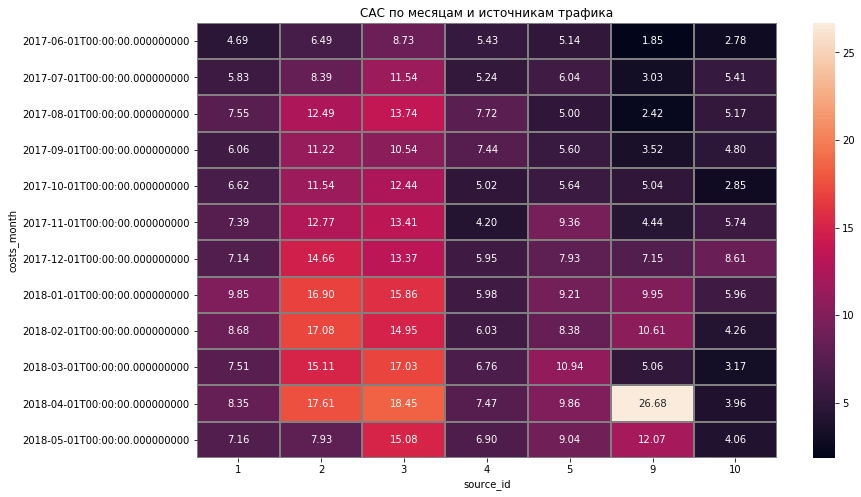

In [142]:
# сводник по месяцам и источникам
cac_pivot = cost_per_user.pivot_table(index='costs_month', columns='source_id', values='cac_per_user', aggfunc='mean').round(2)
#Тепловая карта CAC по месяцам 
plt.figure(figsize=(13, 8))
plt.title('CAC по месяцам и источникам трафика')
sns.heatmap(cac_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.show()

In [143]:
#сбрасываем индексы, чтобы получить использовать costs_month в графике
cac_pivot_reset = cac_pivot.reset_index()

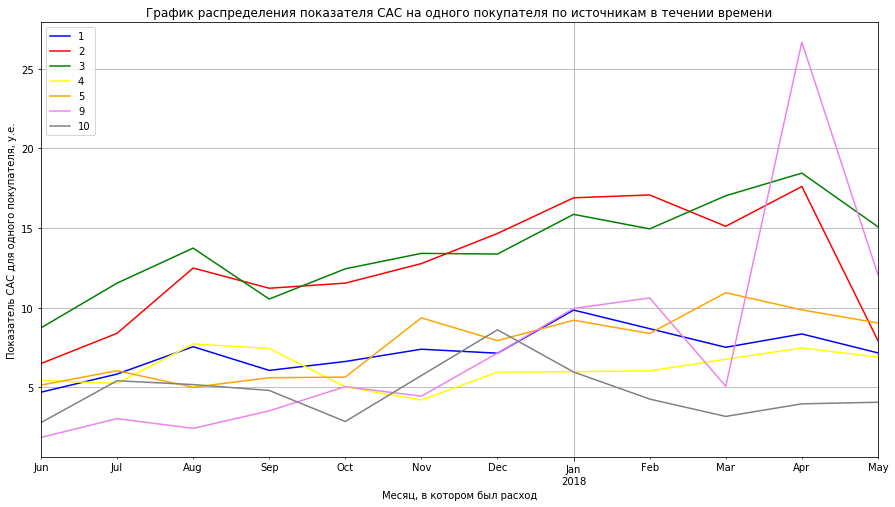

In [144]:
#график распределения CAC по источникам в течении времени  

ax=cac_pivot_reset.plot(color='blue', alpha = 1, y=1 , x='costs_month', figsize=(15, 8), grid = True)

cac_pivot_reset.plot(color='red', alpha = 1, y =2, x='costs_month', figsize=(15, 8), grid=True,ax=ax)

cac_pivot_reset.plot(color='green', alpha = 1, y =3 , x='costs_month', figsize=(15, 8), grid=True, ax=ax)

cac_pivot_reset.plot(color='yellow', alpha = 1, y =4, x='costs_month', figsize=(15, 8),grid=True, ax=ax)

cac_pivot_reset.plot(color='orange', alpha = 1, y =5, x='costs_month', figsize=(15, 8), grid=True, ax=ax)

cac_pivot_reset.plot(color='violet', alpha = 1, y =9, x='costs_month', figsize=(15, 8), grid=True, ax=ax)

cac_pivot_reset.plot(color='grey', alpha = 1, y =10, x='costs_month', figsize=(15, 8), grid=True, ax=ax)


plt.xlabel('Месяц, в котором был расход')

plt.ylabel('Показатель CAC для одного покупателя, у.е.')

plt.title('График распределения показателя CAC на одного покупателя по источникам в течении времени')

plt.show()

*Вывод:*

- Наблюдается рост показателя CAC во по источникам 1, 2, 3, 5, 9 с пиком в районе января-апреля 2018 г с дальнейшим снижением.
  При этом интенсивность и ставбильность у них отличаются. Например, источник 9 имеет резкие скачки, в то время как источник 1   имеет плавный рост и снижением при незначительной амплитуде. 
- Источник 10  имеет почти постоянный показатель CAC с небольшим пиком декабре, видимо обусловленным сезонным ростом продаж.
- Источник 4 также имеет стабильное среднее значение CAC, но пик приходится на август-сентябрь, с провалом в ноябре и   
  дальнейшим плавным увеличением к апрелю.
  
Возможно источники привлекают специфический трафик, колебания которого обусловлены сезонностью. 

### ROMI по когортам  разрезе источников трафика

In [145]:
visits_clear

,device,end_ts,source_id,start_ts,uid,start_ts_year,start_ts_month,start_ts_week,start_ts_date,session_duration_sec,first_visit_date,first_visit_month,visit_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080,2017-12-20,2017-12-01,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680,2018-02-19,2018-02-01,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0,2017-07-01,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440,2018-03-09,2018-03-01,2018-05-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0,2017-12-27,2017-12-01,2017-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017,7,30,2017-07-29,19,2017-07-29,2017-07-01,2017-07-01
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018,1,4,2018-01-25,19,2018-01-25,2018-01-01,2018-01-01
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018,3,9,2018-03-03,19,2018-03-03,2018-03-01,2018-03-01
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017,11,44,2017-11-02,19,2017-11-02,2017-11-01,2017-11-01


In [146]:
#сортируем пользователей по uid и дате первого визита, затем группируем по uid и пределах окна каждого пользователя,применяем
#метод first для отсортированных данных источника трафика и месяца первого визита
visits_for_romi = uid_source_month.copy()
visits_for_romi

,uid,source_id,first_visit_month
0,11863502262781,3,2018-03-01
1,49537067089222,2,2018-02-01
2,297729379853735,3,2017-06-01
3,313578113262317,2,2017-09-01
4,325320750514679,5,2017-09-01
...,...,...,...
228124,18446403737806311543,5,2017-11-01
228125,18446424184725333426,4,2017-12-01
228126,18446556406699109058,3,2018-01-01
228127,18446621818809592527,4,2017-12-01


In [147]:
# таблица с заказами
orders_clear

,buy_ts,revenue,uid,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01
...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-01
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-01
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-01
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-01


In [148]:
#добавляем в таблицу с заказами добавляем дату первого визита и первого источника
orders_for_romi = orders_clear.merge(visits_for_romi, on ='uid', how ='left')
orders_for_romi

,buy_ts,revenue,uid,order_month,source_id,first_visit_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,1,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,3,2017-06-01
...,...,...,...,...,...,...
50409,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-01,4,2018-05-01
50410,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-01,10,2018-05-01
50411,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-01,3,2018-05-01
50412,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-01,3,2017-10-01


In [149]:
# формируем когорты (по первому месяцу визита) и считаем суммарный доход по месяцам жизни
cohorts_for_romi = orders_for_romi.groupby(['first_visit_month','order_month','source_id']).agg({'revenue':'sum'}).reset_index()
cohorts_for_romi

,first_visit_month,order_month,source_id,revenue
0,2017-06-01,2017-06-01,1,1378.70
1,2017-06-01,2017-06-01,2,1043.68
2,2017-06-01,2017-06-01,3,2804.34
3,2017-06-01,2017-06-01,4,1959.84
4,2017-06-01,2017-06-01,5,1898.89
...,...,...,...,...
534,2018-05-01,2018-05-01,4,2516.80
535,2018-05-01,2018-05-01,5,1697.01
536,2018-05-01,2018-05-01,9,83.82
537,2018-05-01,2018-05-01,10,364.34


In [150]:
# посчитаем размер (сколько человек, сделавших заказ покупателей) когорт по первому визиту и источнику
cohort_size_for_romi = orders_for_romi.groupby(['first_visit_month','source_id']).agg({'uid':'nunique'}).reset_index()
cohort_size_for_romi.columns = ['first_visit_month','source_id', 'n_buyers']
cohort_size_for_romi

,first_visit_month,source_id,n_buyers
0,2017-06-01,1,240
1,2017-06-01,2,374
2,2017-06-01,3,886
3,2017-06-01,4,647
4,2017-06-01,5,509
...,...,...,...
79,2018-05-01,3,624
80,2018-05-01,4,611
81,2018-05-01,5,406
82,2018-05-01,9,30


In [151]:
#объединяем данные о размере когорт с когортами
report_for_romi = pd.merge(cohorts_for_romi, cohort_size_for_romi, how='left', left_on=['first_visit_month','source_id'], right_on = ['first_visit_month','source_id'])
report_for_romi

,first_visit_month,order_month,source_id,revenue,n_buyers
0,2017-06-01,2017-06-01,1,1378.70,240
1,2017-06-01,2017-06-01,2,1043.68,374
2,2017-06-01,2017-06-01,3,2804.34,886
3,2017-06-01,2017-06-01,4,1959.84,647
4,2017-06-01,2017-06-01,5,1898.89,509
...,...,...,...,...,...
534,2018-05-01,2018-05-01,4,2516.80,611
535,2018-05-01,2018-05-01,5,1697.01,406
536,2018-05-01,2018-05-01,9,83.82,30
537,2018-05-01,2018-05-01,10,364.34,101


In [152]:
#добавляем колонки с валовой прибылью по месяцам и месяцем жизни когорты
report_for_romi['gp'] = report_for_romi['revenue'] * margin_rate
report_for_romi['age'] = (report_for_romi['order_month'] - report_for_romi['first_visit_month'])/np.timedelta64(1, 'M')
report_for_romi['age'] = report_for_romi['age'].round().astype('int')
report_for_romi

,first_visit_month,order_month,source_id,revenue,n_buyers,gp,age
0,2017-06-01,2017-06-01,1,1378.70,240,1378.70,0
1,2017-06-01,2017-06-01,2,1043.68,374,1043.68,0
2,2017-06-01,2017-06-01,3,2804.34,886,2804.34,0
3,2017-06-01,2017-06-01,4,1959.84,647,1959.84,0
4,2017-06-01,2017-06-01,5,1898.89,509,1898.89,0
...,...,...,...,...,...,...,...
534,2018-05-01,2018-05-01,4,2516.80,611,2516.80,0
535,2018-05-01,2018-05-01,5,1697.01,406,1697.01,0
536,2018-05-01,2018-05-01,9,83.82,30,83.82,0
537,2018-05-01,2018-05-01,10,364.34,101,364.34,0


In [153]:
#рассчитаем параметр LTV
report_for_romi['ltv'] = report_for_romi['gp'] / report_for_romi['n_buyers']
report_for_romi

,first_visit_month,order_month,source_id,revenue,n_buyers,gp,age,ltv
0,2017-06-01,2017-06-01,1,1378.70,240,1378.70,0,5.744583
1,2017-06-01,2017-06-01,2,1043.68,374,1043.68,0,2.790588
2,2017-06-01,2017-06-01,3,2804.34,886,2804.34,0,3.165169
3,2017-06-01,2017-06-01,4,1959.84,647,1959.84,0,3.029119
4,2017-06-01,2017-06-01,5,1898.89,509,1898.89,0,3.730629
...,...,...,...,...,...,...,...,...
534,2018-05-01,2018-05-01,4,2516.80,611,2516.80,0,4.119149
535,2018-05-01,2018-05-01,5,1697.01,406,1697.01,0,4.179828
536,2018-05-01,2018-05-01,9,83.82,30,83.82,0,2.794000
537,2018-05-01,2018-05-01,10,364.34,101,364.34,0,3.607327


In [154]:
# считаем расходы по месяцам и источникам
monthly_costs_for_romi = costs.groupby(['costs_month','source_id']).agg({'costs':'sum'}).reset_index()
monthly_costs_for_romi

,costs_month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12
...,...,...,...
79,2018-05-01,3,9411.42
80,2018-05-01,4,4214.21
81,2018-05-01,5,3669.56
82,2018-05-01,9,362.17


In [155]:
#соединяем таблицы с данными о когортах по источникам и расходами на маркетинг по источникам
report_new_for_romi = pd.merge(report_for_romi, monthly_costs_for_romi, how='left', left_on = ['first_visit_month','source_id'], right_on=['costs_month','source_id'])
report_new_for_romi

,first_visit_month,order_month,source_id,revenue,n_buyers,gp,age,ltv,costs_month,costs
0,2017-06-01,2017-06-01,1,1378.70,240,1378.70,0,5.744583,2017-06-01,1125.61
1,2017-06-01,2017-06-01,2,1043.68,374,1043.68,0,2.790588,2017-06-01,2427.38
2,2017-06-01,2017-06-01,3,2804.34,886,2804.34,0,3.165169,2017-06-01,7731.65
3,2017-06-01,2017-06-01,4,1959.84,647,1959.84,0,3.029119,2017-06-01,3514.80
4,2017-06-01,2017-06-01,5,1898.89,509,1898.89,0,3.730629,2017-06-01,2616.12
...,...,...,...,...,...,...,...,...,...,...
534,2018-05-01,2018-05-01,4,2516.80,611,2516.80,0,4.119149,2018-05-01,4214.21
535,2018-05-01,2018-05-01,5,1697.01,406,1697.01,0,4.179828,2018-05-01,3669.56
536,2018-05-01,2018-05-01,9,83.82,30,83.82,0,2.794000,2018-05-01,362.17
537,2018-05-01,2018-05-01,10,364.34,101,364.34,0,3.607327,2018-05-01,409.86


In [156]:
#считаем САС
report_new_for_romi['cac'] = report_new_for_romi['costs'] / report_new_for_romi['n_buyers']
report_new_for_romi

,first_visit_month,order_month,source_id,revenue,n_buyers,gp,age,ltv,costs_month,costs,cac
0,2017-06-01,2017-06-01,1,1378.70,240,1378.70,0,5.744583,2017-06-01,1125.61,4.690042
1,2017-06-01,2017-06-01,2,1043.68,374,1043.68,0,2.790588,2017-06-01,2427.38,6.490321
2,2017-06-01,2017-06-01,3,2804.34,886,2804.34,0,3.165169,2017-06-01,7731.65,8.726467
3,2017-06-01,2017-06-01,4,1959.84,647,1959.84,0,3.029119,2017-06-01,3514.80,5.432457
4,2017-06-01,2017-06-01,5,1898.89,509,1898.89,0,3.730629,2017-06-01,2616.12,5.139725
...,...,...,...,...,...,...,...,...,...,...,...
534,2018-05-01,2018-05-01,4,2516.80,611,2516.80,0,4.119149,2018-05-01,4214.21,6.897234
535,2018-05-01,2018-05-01,5,1697.01,406,1697.01,0,4.179828,2018-05-01,3669.56,9.038325
536,2018-05-01,2018-05-01,9,83.82,30,83.82,0,2.794000,2018-05-01,362.17,12.072333
537,2018-05-01,2018-05-01,10,364.34,101,364.34,0,3.607327,2018-05-01,409.86,4.058020


In [157]:
#считаем ROMI
report_new_for_romi['romi'] = report_new_for_romi['ltv'] / report_new_for_romi['cac']
report_new_for_romi

,first_visit_month,order_month,source_id,revenue,n_buyers,gp,age,ltv,costs_month,costs,cac,romi
0,2017-06-01,2017-06-01,1,1378.70,240,1378.70,0,5.744583,2017-06-01,1125.61,4.690042,1.224847
1,2017-06-01,2017-06-01,2,1043.68,374,1043.68,0,2.790588,2017-06-01,2427.38,6.490321,0.429962
2,2017-06-01,2017-06-01,3,2804.34,886,2804.34,0,3.165169,2017-06-01,7731.65,8.726467,0.362709
3,2017-06-01,2017-06-01,4,1959.84,647,1959.84,0,3.029119,2017-06-01,3514.80,5.432457,0.557596
4,2017-06-01,2017-06-01,5,1898.89,509,1898.89,0,3.730629,2017-06-01,2616.12,5.139725,0.725842
...,...,...,...,...,...,...,...,...,...,...,...,...
534,2018-05-01,2018-05-01,4,2516.80,611,2516.80,0,4.119149,2018-05-01,4214.21,6.897234,0.597218
535,2018-05-01,2018-05-01,5,1697.01,406,1697.01,0,4.179828,2018-05-01,3669.56,9.038325,0.462456
536,2018-05-01,2018-05-01,9,83.82,30,83.82,0,2.794000,2018-05-01,362.17,12.072333,0.231438
537,2018-05-01,2018-05-01,10,364.34,101,364.34,0,3.607327,2018-05-01,409.86,4.058020,0.888938


Напишем функцию для вывода тепловых карт ROMI по  источникам

In [158]:
#список источников
source_id_list = list(report_new_for_romi['source_id'].unique())
source_id_list

[1, 2, 3, 4, 5, 9, 10]

In [159]:
#пишем функцию для вывода ROMI по источнику

def romi_source(source):

 #пустые датафреймы
    report_new_for_romi_source = []
    output_for_romi_source = []
    output_for_romi_cum_source =[]
    
    #отфильтруем report_new_for_romi для источника = i
    report_new_for_romi_source= report_new_for_romi[report_new_for_romi['source_id'] ==source]

    #сделаем сводник для i-го источника
    output_for_romi_source = report_new_for_romi_source.pivot_table(
    index='first_visit_month', columns='age', values='romi', aggfunc='mean')

    #считаем накопительный romi
    output_for_romi_cum_source = output_for_romi_source.cumsum(axis=1).round(2)
    
    #Вывод названия
    print()
    print('Тепловая карта накопительного ROMI для источника №', source)

    #выводим тепловую карту
    plt.figure(figsize=(13, 8))
    plt.title('Накопительный ROMI по когортам и месяцам жизни когорт с источником')
    sns.heatmap(output_for_romi_cum_source, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
    plt.show()
    
    #средний romi
    romi_mean_source = output_for_romi_cum_source.mean(axis=0).reset_index()
    romi_mean_source.columns = ['age','romi_mean_cohorts']
    print()
    print('ROMI для средней когорты:')
    display(romi_mean_source)
    
    #график изменения накопительного ROMI для средней когорты в течении времени жизни  

    romi_mean_source.plot(color='blue', alpha = 1, y= 'romi_mean_cohorts' , x='age', figsize=(15, 8), grid = True)
    plt.xlabel('Месяц жизни средней когорты')
    plt.ylabel('ROMI для средней когорты накопительный, у.е.')
    plt.title('График изменения ROMI для средней когорты в течении времени жизни')
    plt.show()


Тепловая карта накопительного ROMI для источника № 1


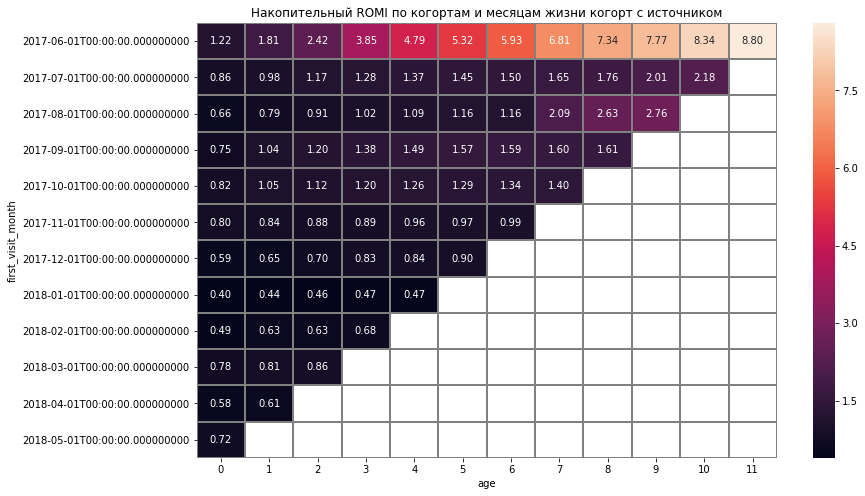


ROMI для средней когорты:


,age,romi_mean_cohorts
0,0,0.722500
1,1,0.877273
2,2,1.035000
3,3,1.288889
4,4,1.533750
5,5,1.808571
6,6,2.085000
7,7,2.710000
8,8,3.335000
9,9,4.180000


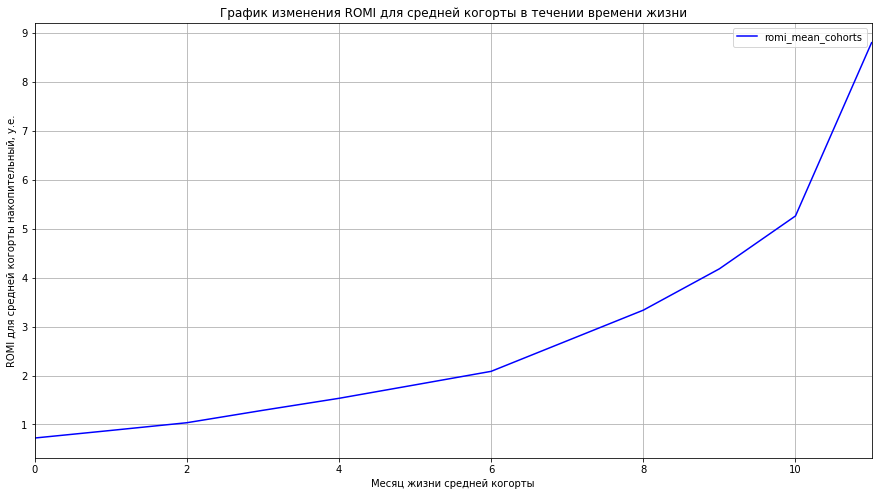

In [160]:
# накопительный ROMI по 1 источнику
romi_source(1)


Тепловая карта накопительного ROMI для источника № 2


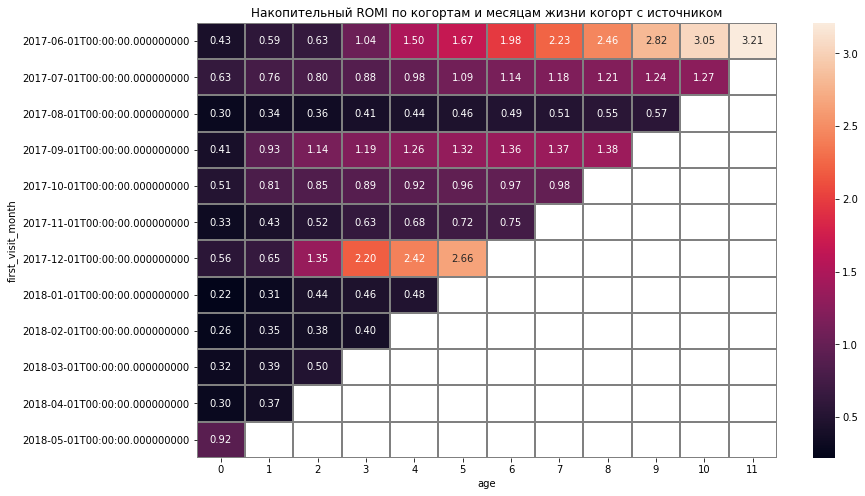


ROMI для средней когорты:


,age,romi_mean_cohorts
0,0,0.432500
1,1,0.539091
2,2,0.697000
3,3,0.900000
4,4,1.085000
5,5,1.268571
6,6,1.115000
7,7,1.254000
8,8,1.400000
9,9,1.543333


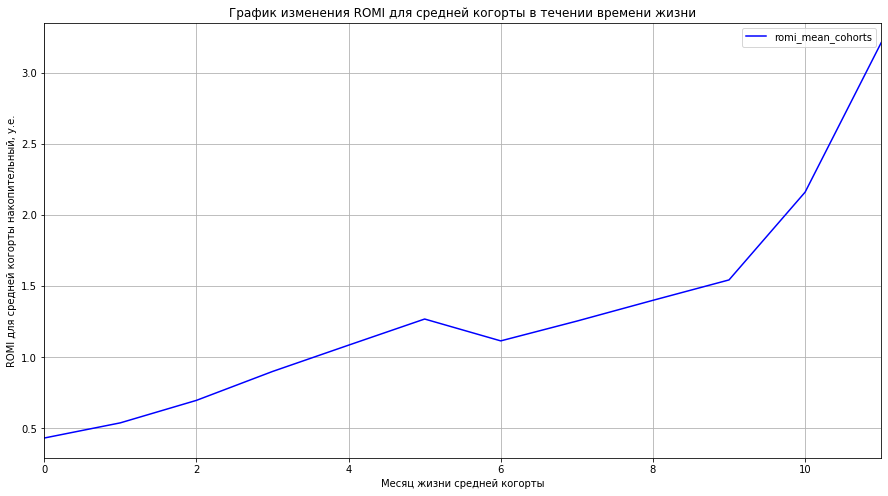

In [161]:
# накопительный ROMI по 2 источнику
romi_source(2)


Тепловая карта накопительного ROMI для источника № 3


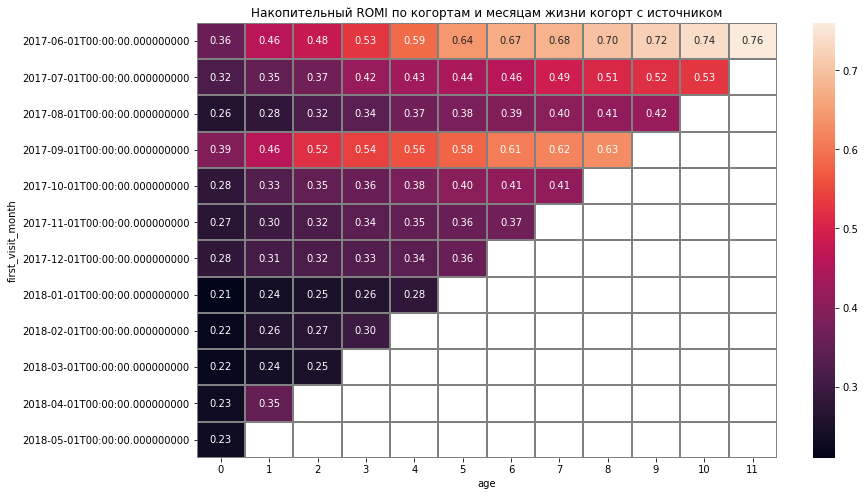


ROMI для средней когорты:


,age,romi_mean_cohorts
0,0,0.272500
1,1,0.325455
2,2,0.345000
3,3,0.380000
4,4,0.412500
5,5,0.451429
6,6,0.485000
7,7,0.520000
8,8,0.562500
9,9,0.553333


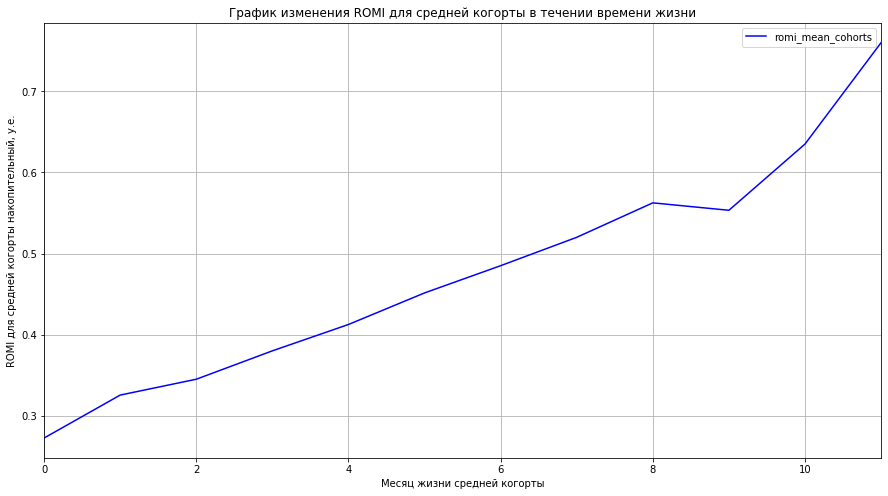

In [162]:
# накопительный ROMI по 3 источнику
romi_source(3)


Тепловая карта накопительного ROMI для источника № 4


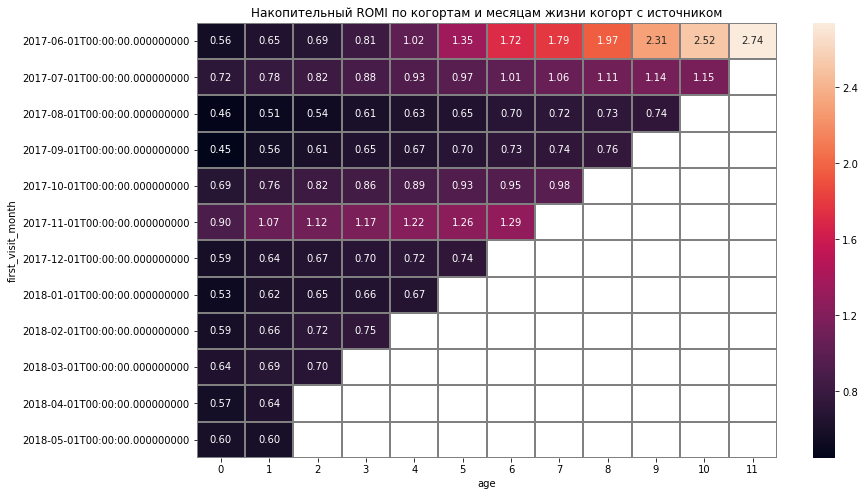


ROMI для средней когорты:


,age,romi_mean_cohorts
0,0,0.608333
1,1,0.681667
2,2,0.734000
3,3,0.787778
4,4,0.843750
5,5,0.942857
6,6,1.066667
7,7,1.058000
8,8,1.142500
9,9,1.396667


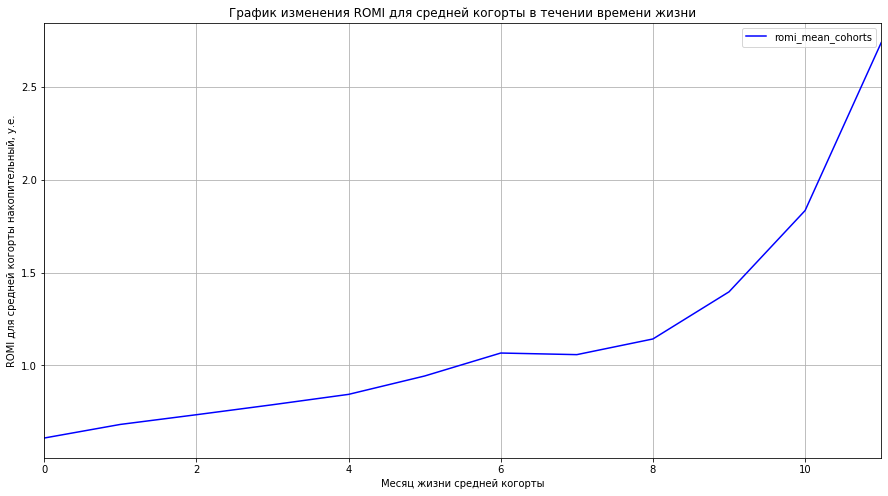

In [163]:
# накопительный ROMI по 4 источнику
romi_source(4)


Тепловая карта накопительного ROMI для источника № 5


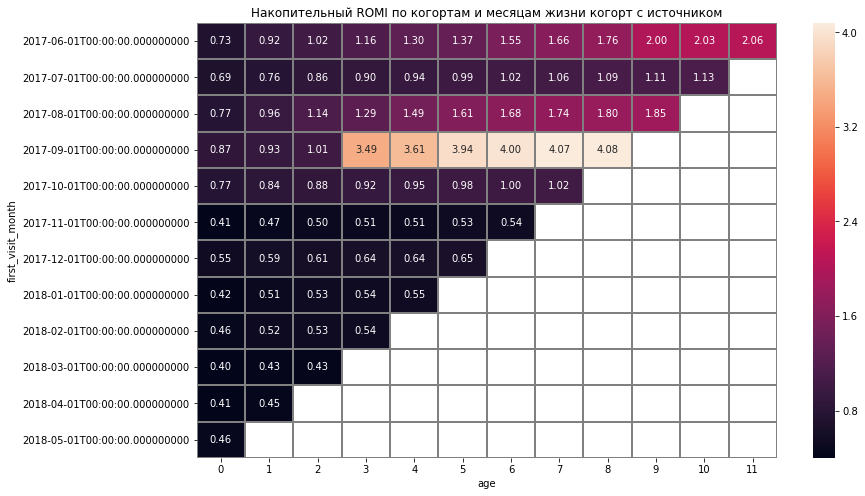


ROMI для средней когорты:


,age,romi_mean_cohorts
0,0,0.578333
1,1,0.670909
2,2,0.751000
3,3,1.110000
4,4,1.248750
5,5,1.438571
6,6,1.631667
7,7,1.910000
8,8,2.182500
9,9,1.653333


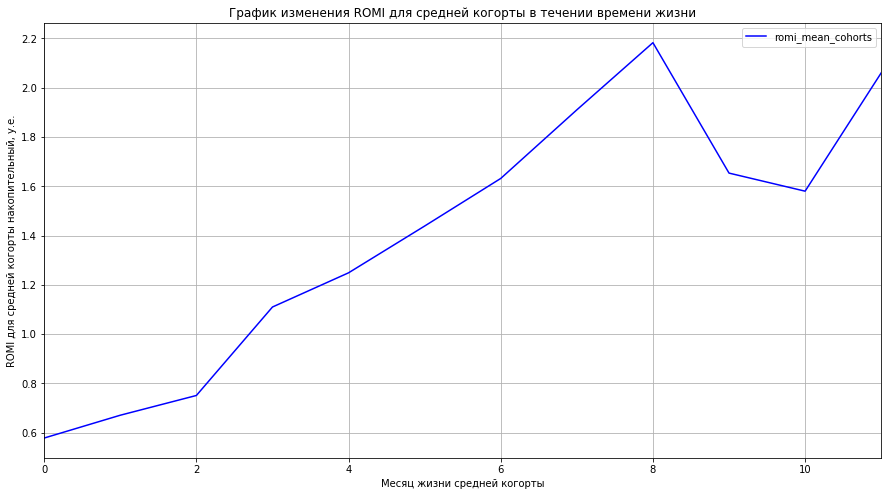

In [164]:
# накопительный ROMI по 5 источнику
romi_source(5)


Тепловая карта накопительного ROMI для источника № 9


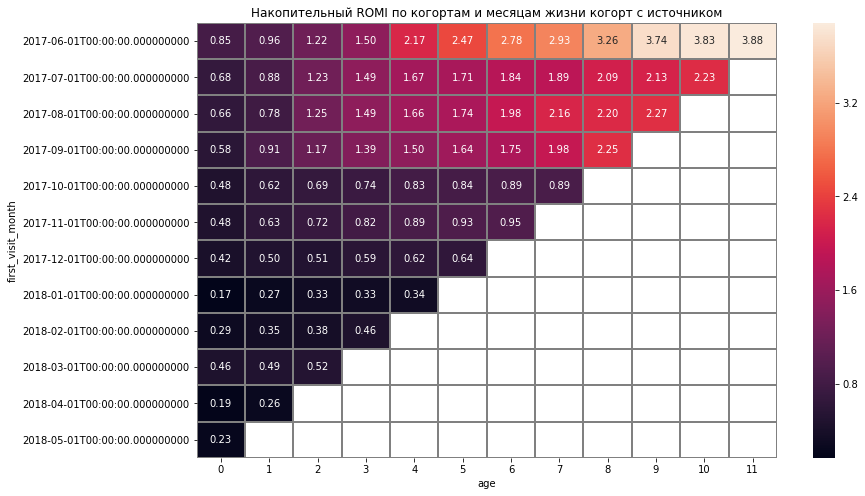


ROMI для средней когорты:


,age,romi_mean_cohorts
0,0,0.457500
1,1,0.604545
2,2,0.802000
3,3,0.978889
4,4,1.210000
5,5,1.424286
6,6,1.698333
7,7,1.970000
8,8,2.450000
9,9,2.713333


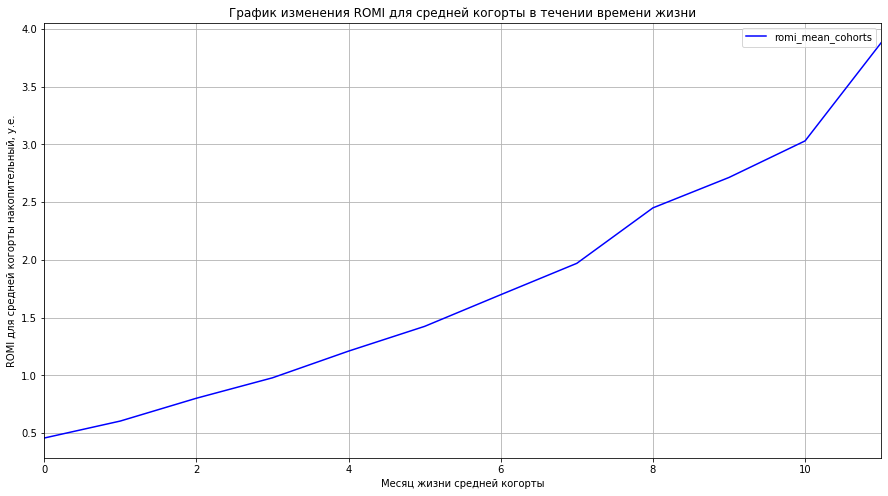

In [165]:
# накопительный ROMI по 9 источнику
romi_source(9)


Тепловая карта накопительного ROMI для источника № 10


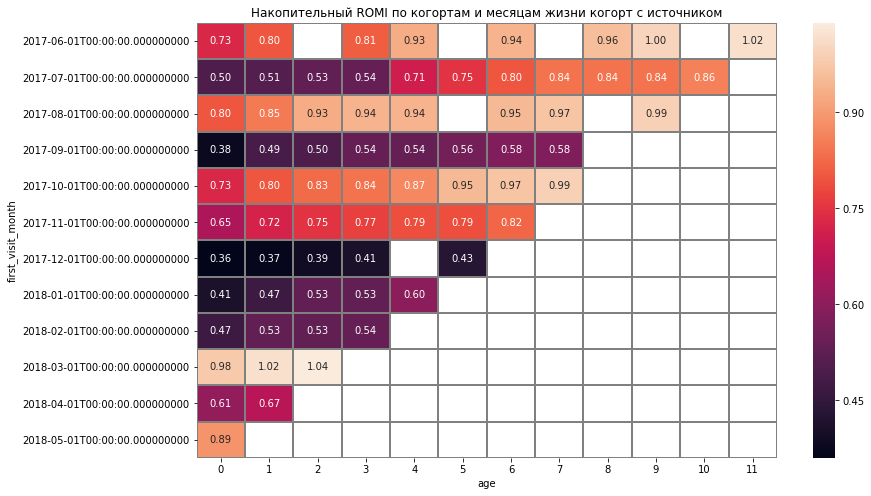


ROMI для средней когорты:


,age,romi_mean_cohorts
0,0,0.625833
1,1,0.657273
2,2,0.670000
3,3,0.657778
4,4,0.768571
5,5,0.696000
6,6,0.843333
7,7,0.845000
8,8,0.900000
9,9,0.943333


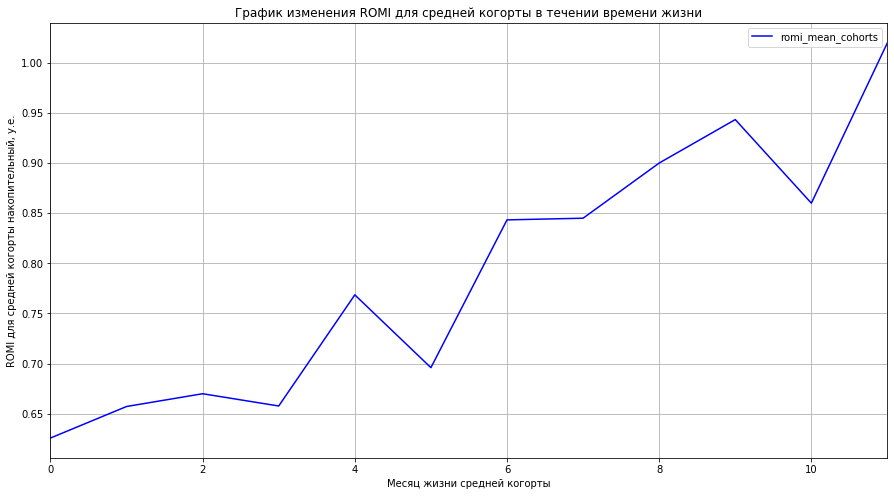

In [166]:
# накопительный ROMI по 10 источнику
romi_source(10)

*Вывод:*

Оценка ROMI для средней когорты показала,что окупаемость наступает на следующих месяцах жизни для различных источников:
- 1-й источник: 2-й месяц жизни;
- 2-й источник: 4-й месяц жизни;
- 3-й источник: не вышел на окупаемость к концу 11-го месяца жизни;
- 4-й источник: 6-й месяц жизни;
- 5-й источник: 3-й месяц жизни;
- 9-й источник: 4-й месяц жизни;
- 10-й источник: 11-й месяц жизни.

<a name="conclusion"></a>
## Общие выводы.

### Приоритетный источник трафика.

Исходя из результатов оценки сроков окупаемости для средней когорты у различных источников трафика, можно сформулировать следующий вывод о приоритете источников(в порядке убывания): 
  
 1) наименьший срок окупаемости у 1-го и 5-го источника;
 
 2) немного больший срок имеют 2-й и 9-й - они также очень интересны;

 3) источник 4 окупается дольше, но его можно использовать как дополнительный с меньшим финансированием;
 
 4) источник 10 окупается только в конце 11-го месяца жизни - использовать, как дополнительный с минимальным финансированием, для диверсификации источников.
 
 5) источник № 3 необходимо отбросить - он не окупается.

### Выводы по метрикам.

1) Сравнение графиков кол-ва уникальных посетителей (WAU, MAU) и расходов на рекламу показывает схожие тендеции - также имеется рост с последующим снижением. При этом пик также приходится на ноябрь и декабрь 2017 года. Таким образом, нельзя сделать однозначный вывод чем обусловлена динамика изменения посетителей - сезонностью и расходами на рекламу. Возможно синергетически накладываются оба фактора. 
 
2) Типичная длительность пользовательской сессии - 60 секунд 
Мы рассмотрели два предположения: а) пользователь за это время находит то, что ему нужно и уходит и б)у пользователя возникает нерешаемая проблема и он уходит. 
В качестве одной из гипотез мы проверили предположение о возможности проблем с мобильным приложением. В срезе с сессией менее 60 секунд соотношение устройств хоть и отличается в сторону увеличения, но не настолько, чтобы можно было говорить о серьезной проблеме с работой мобильной версии. 
Таким образом, останавливаемся на предположении о том, что пользователь быстро находит информацию и уходит, т.к. он не планировал покупку. Рекомендация для маркетологов - возможно в эти 60 секунд необходимо показать пользователь релевантное предложение о покупке по акции или начислении бонусов. Это может увеличить конверсию из информационных запросов.

3) Во всех исследуемых плоскостях наблюдается снижение коэффициента удержания. Что делает его влияние крайне незначительным. Фактически пользователь используется 1 раз - это значит за каждого нового пользователя нужно платить заново стоимость CAC. Это приводит к большому перерасходу средств на маркетинг и делает невозможным масштабное развитие.
Такой большой отток пользователей после первого месяца использования, говорит либо о их крайней неудовлетворенности сервисом, либо о недостаточном информировании и отсутствии работы с существующей базой клиентов. 

4) Наиболее типичное время между покупкой и первым визитом составляет ноль дней, т.е. посетитель либо становится покупателем в тот же день, либо уходит.

5) Среднее количество покупок за 6 месяцев для уникального покупателя - 1.32. Этот показатель хорошо коррелирует с данными о поведении когорт при визитах - после первого месяца возвращается очень маленькое количество пользователей. Здесь также наблюдается отток клиентов  - лишь немногие делают второй заказ. Необходимо понять причины.

6) Средний чек меняется в течении года незначительно. Это скорее всего обусловленно сезонностью и видом продаваемых товаров.

### Выводы по когортному анализу.

По результатам когортного анализа наибольший интерес представляют следующие когорты: 2017-06-01 и 2017-09-01.
Когорта 2017-09-01 на третьем месяца имеет высокий LTV, который продолжает расти.
Когорта 2017-06-01 с первого месяца высокими темпами увеличивает LTV посравнению с большинством других когорт.
Желательно постараться определить причины этой успешности. Возможно это сезонность и это не получится масштабировать.
Но есть вероятность того, что причины этого другие и учтя их, можно добиться более быстрой окупаемости.